# PSNF (Protein-Shielded Nanocrystal Foundry) proof-of-concept
Simulated datasets + analysis + visualizations

## What this does
1) Simulates PSNF experiments (nanoreactor → shield → field/flow assembly → lock-in)
2) Uses numeric anchors benchmarked from PubMed-indexed papers (see citations below)
3) Visualizes dataset distributions and key relationships
4) Trains a classifier to predict “Month 18 pass” and ranks candidate experiments

## Journal anchors used (numbers appear in the simulator design):
- Encapsulin-contained iron oxide cores ~24 ± 8 nm and ~32 nm shell size (Sigmund et al. Nat Commun 2018, PubMed: 29777103;
  plus encapsulin biomineralization reports; example core sizes commonly ~20–30 nm range)
- Magnetosome SAXS-derived radius ~19 nm (diameter ~38 nm) and spacing ~53 nm (Rosenfeldt et al. Appl Environ Microbiol 2019, PubMed: 31604767)
- Cobalt ferrite example: ~36 nm grain size with coercivity ~2020 Oe (2.02 kOe) and squareness ~0.53 (Chinnasamy et al. J Appl Phys 2003, PubMed: 12804888)

## Notes
- This is a synthetic dataset meant to demonstrate your ML + quantitative workflow, not to claim real performance.
- “Month 18 pass” is deliberately rare because it requires meeting many hard thresholds simultaneously.


Dataset head:
           reactor chelator      redox               shield  pore_gating  \
0      encapsulin   strong  oxidizing   sacrificial_matrix     0.890948   
1  ferritin_rules     none  oxidizing         peptide_thin    -1.173817   
2  ferritin_rules     weak   reducing         peptide_thin     1.045803   
3      encapsulin     weak   reducing   sacrificial_matrix     0.206516   
4      encapsulin     weak  oxidizing  protein_matrix_perm    -0.606409   
5  ferritin_rules   strong       mild        protein_shell    -1.429460   
6      encapsulin     weak       mild         peptide_thin    -0.285423   
7  ferritin_rules     weak       mild                 none    -0.062847   
8  ferritin_rules     weak       mild         peptide_thin    -0.094471   
9      encapsulin     weak       mild         peptide_thin    -0.513594   

   luminal_charge  cargo_loading  phosphorus_free  feed_rate  crosslink  ...  \
0        0.301212       0.824941                1   1.033469   0.443995  ...  

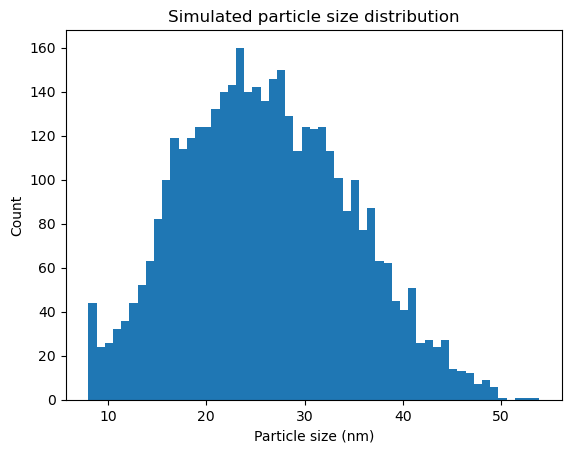

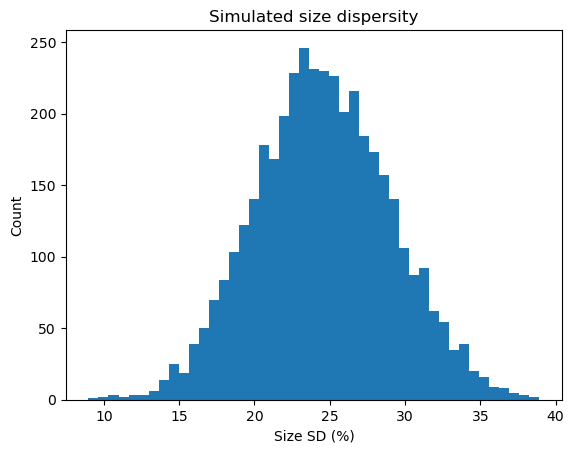

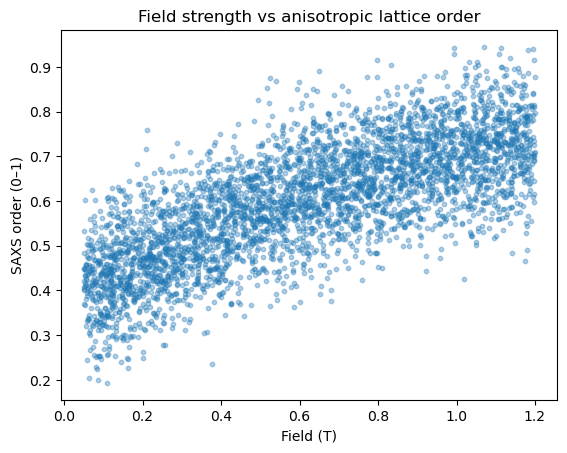

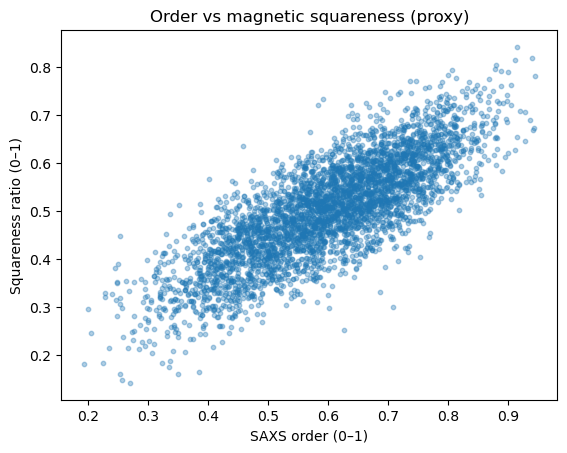


Pass rates by shield:
                      m18_pass  m36_pass
shield                                 
protein_matrix_perm  0.003910  0.000978
sacrificial_matrix   0.002497  0.001248
peptide_thin         0.001013  0.001013
none                 0.000000  0.000000
protein_shell        0.000000  0.001244


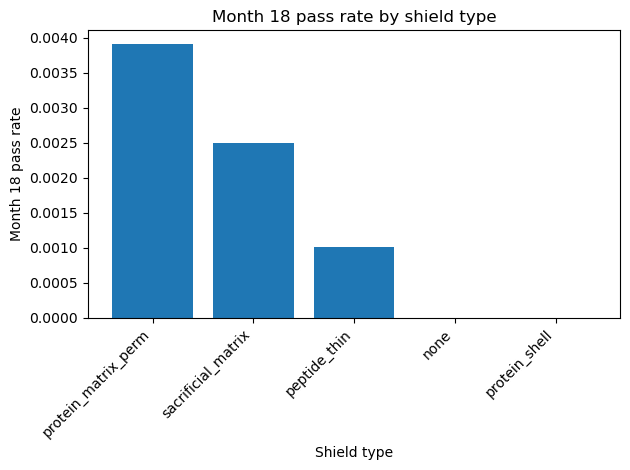


Classifier report (AUC stored in row 'AUC', column 'f1-score'):
               precision  recall  f1-score   support
0              0.998000   1.000  0.998999   998.000
1              0.000000   0.000  0.000000     2.000
accuracy       0.998000   0.998  0.998000     0.998
macro avg      0.499000   0.500  0.499499  1000.000
weighted avg   0.996004   0.998  0.997001  1000.000
AUC                 NaN     NaN  1.000000       NaN

Top feature importances:
                  feature  importance
23           size_sd_pct    0.186958
30            squareness    0.150127
26            saxs_order    0.128041
19               field_T    0.108722
24  crystalline_fraction    0.079596
29        coercivity_kOe    0.072892
3        chelator_strong    0.050445
22      particle_size_nm    0.042189
13           pore_gating    0.041736
28        single_solid_g    0.031474
25    air_stability_days    0.028565
14        luminal_charge    0.016431
17             feed_rate    0.008934
20             shear_s-1 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


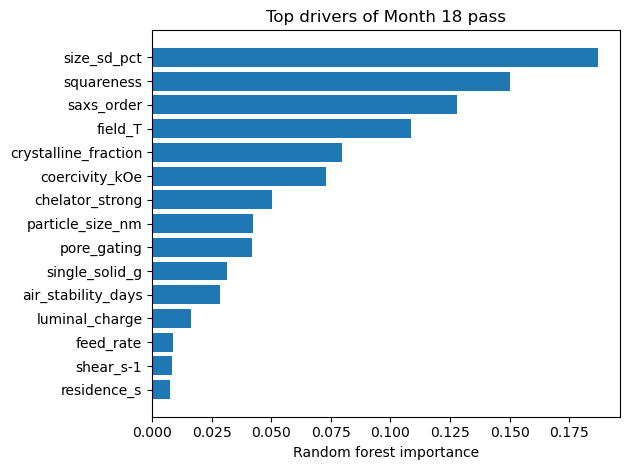


Median conditions among Month 18 successes:
    n_success  field_T_median  shear_s-1_median  residence_s_median  \
0          7        0.951255        100.957595           70.944988   

   crosslink_median  size_sd_pct_median  crystalline_fraction_median  \
0          0.563613           13.232947                     0.486853   

   air_stability_days_median  yield_g_median  single_solid_g_median  \
0                    16.7927       14.850507               1.183906   

   saxs_order_median  
0            0.80384  

Top 20 recommended candidate runs:
       pred_m18_prob         reactor chelator      redox               shield  \
1623       0.373804      encapsulin   strong  oxidizing  protein_matrix_perm   
1573       0.282447      encapsulin   strong       mild  protein_matrix_perm   
130        0.279576      encapsulin   strong   reducing   sacrificial_matrix   
897        0.136929      encapsulin   strong  oxidizing         peptide_thin   
695        0.111210      encapsulin     we

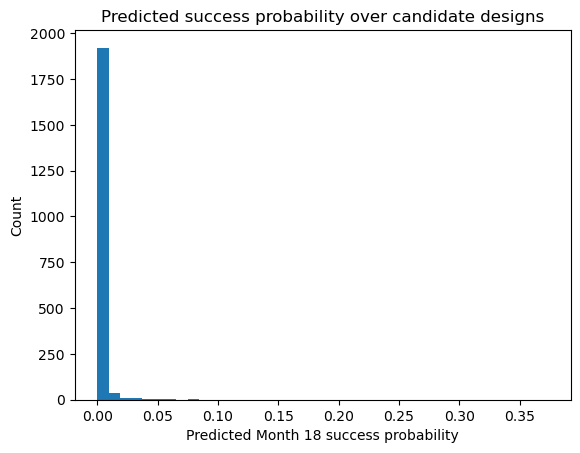

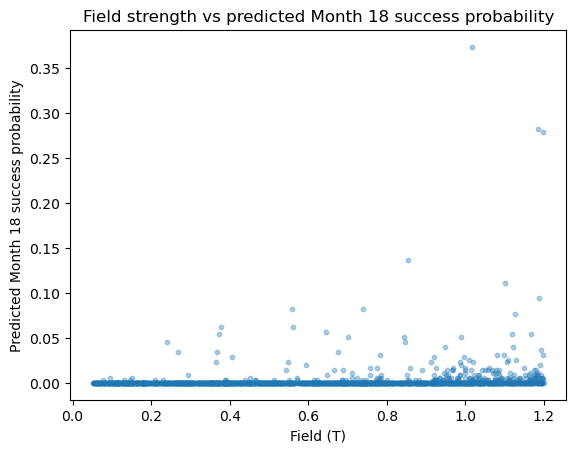

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Helpers

def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))

# Simulator

@dataclass
class PassThresholds:
    # Month 18 (TA1.3-like) operational thresholds
    total_yield_g: float = 10.0
    single_solid_g: float = 1.0
    size_sd_pct_max: float = 15.0
    crystalline_fraction_min: float = 0.40
    saxs_order_min: float = 0.70
    air_stability_days_min: float = 14.0

    # Month 36 (functional proxy thresholds)
    squareness_min: float = 0.80
    coercivity_kOe_min: float = 1.00


def simulate_psnf_experiments(
    n: int = 5000,
    seed: int = 7,
    thresholds: PassThresholds | None = None
) -> pd.DataFrame:
    """
    Simulate PSNF experiments with knobs for:
    - reactor type & interior chemistry (controls size/dispersion/crystallinity)
    - shield type (controls air stability and assembly compatibility)
    - field + shear + residence + crosslink (controls SAXS order and lock-in)

    Output includes:
    - particle_size_nm, size_sd_pct, crystalline_fraction, air_stability_days, saxs_order
    - yield_g, single_solid_g
    - magnetic proxies: coercivity_kOe, squareness
    - binary pass flags: m18_pass, m36_pass
    """
    if thresholds is None:
        thresholds = PassThresholds()

    rng = np.random.default_rng(seed)

    # Categorical design knobs
    reactor = rng.choice(["encapsulin", "ferritin_rules"], size=n, p=[0.65, 0.35])
    chelator = rng.choice(["none", "weak", "strong"], size=n, p=[0.30, 0.45, 0.25])
    redox = rng.choice(["mild", "oxidizing", "reducing"], size=n, p=[0.60, 0.20, 0.20])
    shield = rng.choice(
        ["none", "peptide_thin", "protein_shell", "protein_matrix_perm", "sacrificial_matrix"],
        size=n,
        p=[0.10, 0.25, 0.20, 0.25, 0.20]
    )

    # Continuous design knobs
    pore_gating = rng.normal(0.0, 0.9, size=n)            # negative = tighter gating
    luminal_charge = rng.normal(0.0, 1.0, size=n)         # more negative = more nucleation
    cargo_loading = rng.uniform(0.2, 1.0, size=n)         # occupancy
    phosphorus_free = rng.choice([0, 1], size=n, p=[0.55, 0.45])

    feed_rate = rng.lognormal(mean=np.log(1.0), sigma=0.6, size=n)  # relative feed rate
    crosslink = rng.beta(a=2.2, b=2.2, size=n)                      # 0..1 lock-in strength

    field_T = rng.uniform(0.05, 1.2, size=n)                        # Tesla-equivalent
    shear_s = rng.lognormal(mean=np.log(150), sigma=0.8, size=n)     # s^-1
    residence_s = rng.uniform(5, 120, size=n)                       # seconds

    # Outputs

    # Particle size model (nm)
    # Anchors: encapsulin core ~24 nm; cobalt ferrite ~36 nm grain size 
    base_mu = np.where(reactor == "encapsulin", 24.0, 36.0)

    chel_eff = np.select([chelator == "none", chelator == "weak", chelator == "strong"], [0.0, -3.0, -7.0])
    pore_eff = -2.5 * pore_gating
    feed_eff = 4.0 * np.log(feed_rate)
    charge_eff = -1.2 * luminal_charge
    cargo_eff = -2.0 * (cargo_loading - 0.6)
    cryst_eff = 2.0 * phosphorus_free

    particle_size_nm = base_mu + chel_eff + pore_eff + feed_eff + charge_eff + cargo_eff + cryst_eff + rng.normal(0, 4.5, size=n)
    particle_size_nm = np.clip(particle_size_nm, 8, 2000)

    # Size dispersity SD (%)
    size_sd_pct = (
        30
        - 4.0 * (reactor == "encapsulin").astype(float)
        - 3.0 * (chelator == "weak").astype(float)
        - 6.0 * (chelator == "strong").astype(float)
        - 2.0 * np.tanh(-pore_gating / 1.2)
        - 1.5 * np.tanh(luminal_charge / 1.5)
        + 1.5 * np.log(feed_rate)
        + rng.normal(0, 3.0, size=n)
    )
    size_sd_pct = np.clip(size_sd_pct, 5, 60)

    # Crystalline fraction (0..1)
    redox_eff = np.select([redox == "mild", redox == "oxidizing", redox == "reducing"], [0.05, 0.09, -0.02])
    shield_eff = np.select(
        [
            shield == "none",
            shield == "peptide_thin",
            shield == "protein_shell",
            shield == "protein_matrix_perm",
            shield == "sacrificial_matrix",
        ],
        [0.00, 0.03, 0.05, 0.02, 0.04]
    )
    crystalline_fraction = (
        0.28
        + 0.10 * phosphorus_free
        + redox_eff
        + shield_eff
        + 0.03 * np.tanh(-pore_gating / 1.0)
        + rng.normal(0, 0.06, size=n)
    )
    crystalline_fraction = np.clip(crystalline_fraction, 0.05, 0.95)

    # Air stability (days)
    stability_base = 2.0 + 8.0 * crystalline_fraction
    stability_shield = np.select(
        [
            shield == "none",
            shield == "peptide_thin",
            shield == "protein_shell",
            shield == "protein_matrix_perm",
            shield == "sacrificial_matrix",
        ],
        [0.0, 7.0, 14.0, 10.0, 9.0]
    )
    air_stability_days = (
        stability_base
        + stability_shield
        - 1.2 * np.log(np.maximum(particle_size_nm, 10) / 24.0)
        + rng.normal(0, 3.5, size=n)
    )
    air_stability_days = np.clip(air_stability_days, 0.5, 120)

    # SAXS order parameter (0..1)
    shield_order_penalty = np.select(
        [
            shield == "none",
            shield == "peptide_thin",
            shield == "protein_shell",
            shield == "protein_matrix_perm",
            shield == "sacrificial_matrix",
        ],
        [0.08, 0.02, 0.03, 0.05, 0.04]
    )
    saxs_order = (
        0.15
        + 0.55 * sigmoid((field_T - 0.25) * 3.0)
        + 0.20 * sigmoid((np.log(shear_s) - np.log(150.0)) * 1.2)
        + 0.10 * sigmoid((residence_s - 25.0) / 15.0)
        + 0.12 * sigmoid((crosslink - 0.45) * 4.0)
        - 0.006 * size_sd_pct
        - shield_order_penalty
        + rng.normal(0, 0.06, size=n)
    )
    saxs_order = np.clip(saxs_order, 0.0, 1.0)

    # Throughput (g) and single solid (g)
    yield_g = (
        rng.lognormal(mean=np.log(8.0), sigma=0.55, size=n)
        + 3.0 * (shield != "none").astype(float)
        + 2.0 * sigmoid((crosslink - 0.4) * 4.0)
        + rng.normal(0, 1.2, size=n)
    )
    yield_g = np.clip(yield_g, 0.2, 60)

    single_solid_g = (
        rng.lognormal(mean=np.log(0.35), sigma=0.7, size=n)
        + 0.45 * (shield == "protein_matrix_perm").astype(float)
        + 0.35 * (shield == "sacrificial_matrix").astype(float)
        + 0.25 * sigmoid((crosslink - 0.45) * 4.0)
        + 0.30 * sigmoid((field_T - 0.25) * 3.0)
        + rng.normal(0, 0.08, size=n)
    )
    single_solid_g = np.clip(single_solid_g, 0.01, 5.0)

    # Magnetic proxies (Month 36 direction)
    oxidation_risk = sigmoid((10.0 - air_stability_days) / 3.5)

    coercivity_kOe = (
        0.6
        + 1.8 * saxs_order
        + 0.8 * crystalline_fraction
        + 0.15 * (reactor == "ferritin_rules").astype(float)
        - 0.01 * size_sd_pct
        - 0.6 * oxidation_risk
        + rng.normal(0, 0.25, size=n)
    )
    coercivity_kOe = np.clip(coercivity_kOe, 0.05, 6.0)

    squareness = (
        0.22
        + 0.60 * saxs_order
        + 0.15 * crystalline_fraction
        - 0.004 * size_sd_pct
        - 0.12 * oxidation_risk
        + rng.normal(0, 0.05, size=n)
    )
    squareness = np.clip(squareness, 0.0, 1.0)

    # Pass flags
    m18_pass = (
        (yield_g > thresholds.total_yield_g)
        & (single_solid_g > thresholds.single_solid_g)
        & (size_sd_pct <= thresholds.size_sd_pct_max)
        & (crystalline_fraction > thresholds.crystalline_fraction_min)
        & (saxs_order >= thresholds.saxs_order_min)
        & (air_stability_days >= thresholds.air_stability_days_min)
    ).astype(int)

    m36_pass = (
        (squareness > thresholds.squareness_min)
        & (coercivity_kOe > thresholds.coercivity_kOe_min)
    ).astype(int)

    df = pd.DataFrame({
        "reactor": reactor,
        "chelator": chelator,
        "redox": redox,
        "shield": shield,
        "pore_gating": pore_gating,
        "luminal_charge": luminal_charge,
        "cargo_loading": cargo_loading,
        "phosphorus_free": phosphorus_free,
        "feed_rate": feed_rate,
        "crosslink": crosslink,
        "field_T": field_T,
        "shear_s-1": shear_s,
        "residence_s": residence_s,
        "particle_size_nm": particle_size_nm,
        "size_sd_pct": size_sd_pct,
        "crystalline_fraction": crystalline_fraction,
        "air_stability_days": air_stability_days,
        "saxs_order": saxs_order,
        "yield_g": yield_g,
        "single_solid_g": single_solid_g,
        "coercivity_kOe": coercivity_kOe,
        "squareness": squareness,
        "m18_pass": m18_pass,
        "m36_pass": m36_pass,
    })
    return df

# Visualization utilities

def plot_hist(series: pd.Series, bins: int, xlabel: str, title: str) -> None:
    plt.figure()
    plt.hist(series.values, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.show()


def plot_scatter(x: pd.Series, y: pd.Series, xlabel: str, ylabel: str, title: str, alpha: float = 0.35) -> None:
    plt.figure()
    plt.scatter(x.values, y.values, s=10, alpha=alpha)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def plot_bar(categories: List[str], values: np.ndarray, xlabel: str, ylabel: str, title: str, rotate: int = 45) -> None:
    plt.figure()
    plt.bar(categories, values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()

# ML analysis

def train_month18_classifier(df: pd.DataFrame, seed: int = 7) -> Tuple[Pipeline, pd.DataFrame]:
    target = "m18_pass"
    X = df.drop(columns=[target, "m36_pass"])
    y = df[target]

    cat_cols = ["reactor", "chelator", "redox", "shield"]
    num_cols = [c for c in X.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ]
    )

    rf = RandomForestClassifier(
        n_estimators=350,
        random_state=seed,
        min_samples_leaf=3,
        n_jobs=-1,
        class_weight="balanced"
    )

    clf = Pipeline([("pre", pre), ("rf", rf)])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )

    clf.fit(X_train, y_train)

    proba = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, proba)

    report = classification_report(y_test, (proba >= 0.5).astype(int), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.loc["AUC", "f1-score"] = auc

    return clf, report_df


def feature_importance_table(clf: Pipeline, df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract feature importances from the RF. Note: expands one-hot encoded feature names.
    """
    X = df.drop(columns=["m18_pass", "m36_pass"])
    cat_cols = ["reactor", "chelator", "redox", "shield"]
    num_cols = [c for c in X.columns if c not in cat_cols]

    ohe: OneHotEncoder = clf.named_steps["pre"].named_transformers_["cat"]
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
    all_feature_names = cat_feature_names + num_cols

    importances = clf.named_steps["rf"].feature_importances_
    imp = pd.DataFrame({"feature": all_feature_names, "importance": importances}).sort_values("importance", ascending=False)
    return imp


def summarize_success_region(df: pd.DataFrame) -> pd.DataFrame:
    success = df[df["m18_pass"] == 1].copy()
    if len(success) == 0:
        return pd.DataFrame([{"n_success": 0, "note": "No successes under current simulation thresholds."}])

    out = pd.DataFrame([{
        "n_success": int(len(success)),
        "field_T_median": float(success["field_T"].median()),
        "shear_s-1_median": float(success["shear_s-1"].median()),
        "residence_s_median": float(success["residence_s"].median()),
        "crosslink_median": float(success["crosslink"].median()),
        "size_sd_pct_median": float(success["size_sd_pct"].median()),
        "crystalline_fraction_median": float(success["crystalline_fraction"].median()),
        "air_stability_days_median": float(success["air_stability_days"].median()),
        "yield_g_median": float(success["yield_g"].median()),
        "single_solid_g_median": float(success["single_solid_g"].median()),
        "saxs_order_median": float(success["saxs_order"].median()),
    }])
    return out


def rank_candidate_experiments(clf: Pipeline, n_candidates: int = 2000, seed: int = 123) -> pd.DataFrame:
    cand = simulate_psnf_experiments(n=n_candidates, seed=seed)
    cand_X = cand.drop(columns=["m18_pass", "m36_pass"])
    cand["pred_m18_prob"] = clf.predict_proba(cand_X)[:, 1]
    return cand.sort_values("pred_m18_prob", ascending=False)

# Main run

if __name__ == "__main__":
    # 1) Simulate dataset
    df = simulate_psnf_experiments(n=4000, seed=7)

    print("\nDataset head:\n", df.head(10))
    print("\nMonth 18 pass rate:", df["m18_pass"].mean())
    print("Month 36 proxy pass rate:", df["m36_pass"].mean())

    # 2) Visualize dataset
    plot_hist(df["particle_size_nm"], bins=55, xlabel="Particle size (nm)", title="Simulated particle size distribution")
    plot_hist(df["size_sd_pct"], bins=45, xlabel="Size SD (%)", title="Simulated size dispersity")

    plot_scatter(df["field_T"], df["saxs_order"], xlabel="Field (T)", ylabel="SAXS order (0–1)",
                 title="Field strength vs anisotropic lattice order")

    plot_scatter(df["saxs_order"], df["squareness"], xlabel="SAXS order (0–1)", ylabel="Squareness ratio (0–1)",
                 title="Order vs magnetic squareness (proxy)")

    pass_rates = df.groupby("shield")[["m18_pass", "m36_pass"]].mean().sort_values("m18_pass", ascending=False)
    print("\nPass rates by shield:\n", pass_rates)

    plot_bar(
        categories=list(pass_rates.index),
        values=pass_rates["m18_pass"].values,
        xlabel="Shield type",
        ylabel="Month 18 pass rate",
        title="Month 18 pass rate by shield type"
    )

    # 3) Train classifier for Month 18 success
    clf, report_df = train_month18_classifier(df, seed=7)
    print("\nClassifier report (AUC stored in row 'AUC', column 'f1-score'):\n", report_df)

    # 4) Feature importance
    imp = feature_importance_table(clf, df)
    print("\nTop feature importances:\n", imp.head(20))

    plt.figure()
    topk = imp.head(15)
    plt.barh(topk["feature"][::-1], topk["importance"][::-1])
    plt.xlabel("Random forest importance")
    plt.title("Top drivers of Month 18 pass")
    plt.tight_layout()
    plt.show()

    # 5) What "good" looks like
    success_summary = summarize_success_region(df)
    print("\nMedian conditions among Month 18 successes:\n", success_summary)

    # 6) Rank new candidate experiments by predicted probability
    ranked = rank_candidate_experiments(clf, n_candidates=2000, seed=123)
    print("\nTop 20 recommended candidate runs:\n", ranked.head(20)[
        ["pred_m18_prob", "reactor", "chelator", "redox", "shield",
         "field_T", "shear_s-1", "residence_s", "crosslink",
         "size_sd_pct", "crystalline_fraction", "air_stability_days",
         "yield_g", "single_solid_g", "saxs_order"]
    ])

    plt.figure()
    plt.hist(ranked["pred_m18_prob"].values, bins=40)
    plt.xlabel("Predicted Month 18 success probability")
    plt.ylabel("Count")
    plt.title("Predicted success probability over candidate designs")
    plt.show()

    plt.figure()
    plt.scatter(ranked["field_T"].values, ranked["pred_m18_prob"].values, s=10, alpha=0.35)
    plt.xlabel("Field (T)")
    plt.ylabel("Predicted Month 18 success probability")
    plt.title("Field strength vs predicted Month 18 success probability")
    plt.show()

#  deeper analysis, sensitivity, and reporting
## Adds:
- threshold stress-testing (how hard is Month 18?)
- partial dependence-style curves (1D sweeps)
- scenario comparison (shield/reactor choices)
- Month 36 proxy model + dual-objective ranking (M18 + M36)
- compact “evidence bundle” tables (ARIA-style)


[Month-18 model] AUC: 1.0

Threshold stress-test (pass rate sensitivity):
                   metric  factor  threshold_used  pass_rate
15    air_stability_days     0.8           11.20    0.00200
16    air_stability_days     1.0           14.00    0.00175
17    air_stability_days     1.2           16.80    0.00075
9   crystalline_fraction     0.8            0.32    0.00175
10  crystalline_fraction     1.0            0.40    0.00175
11  crystalline_fraction     1.2            0.48    0.00100
12            saxs_order     0.8            0.56    0.00200
13            saxs_order     1.0            0.70    0.00175
14            saxs_order     1.2            0.84    0.00050
3         single_solid_g     0.8            0.80    0.00175
4         single_solid_g     1.0            1.00    0.00175
5         single_solid_g     1.2            1.20    0.00075
6            size_sd_pct     0.8           12.00    0.00075
7            size_sd_pct     1.0           15.00    0.00175
8            size_sd_pct

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


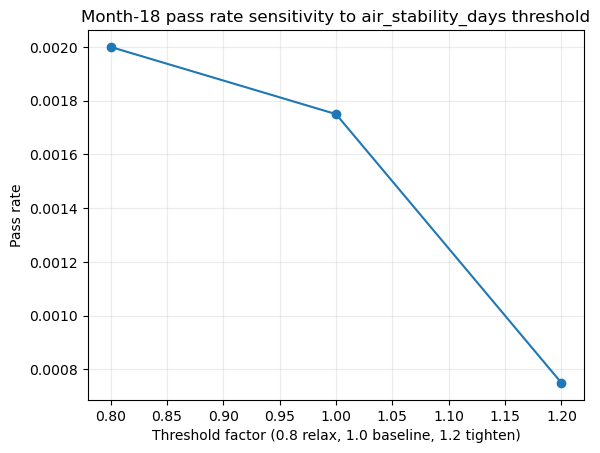

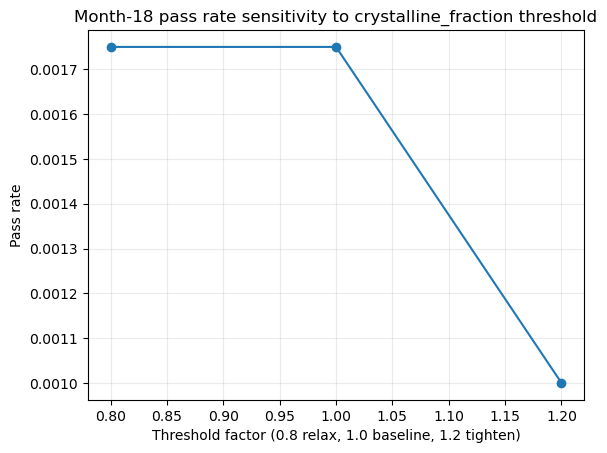

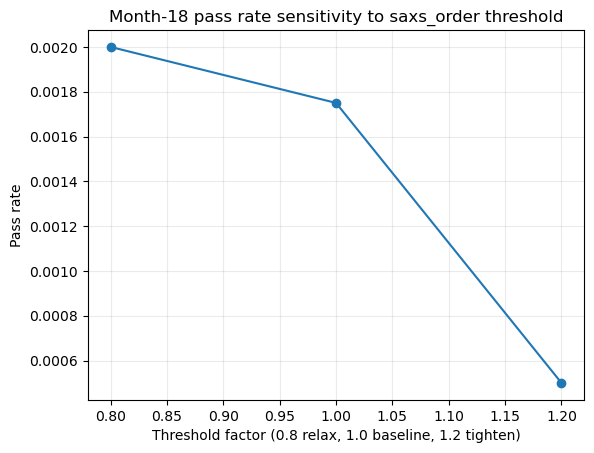

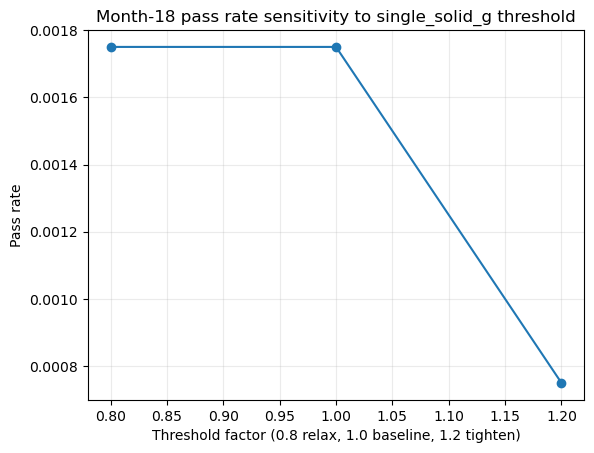

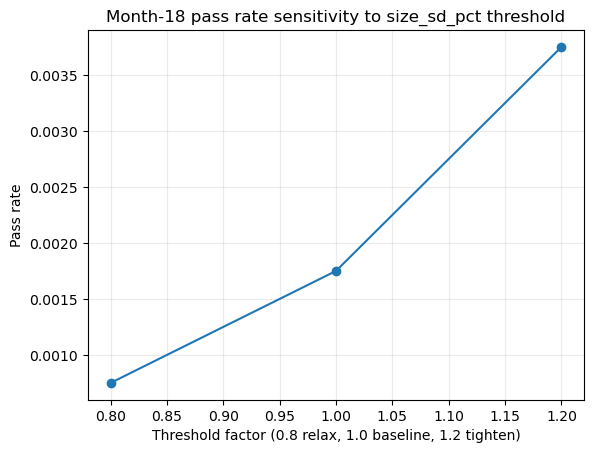

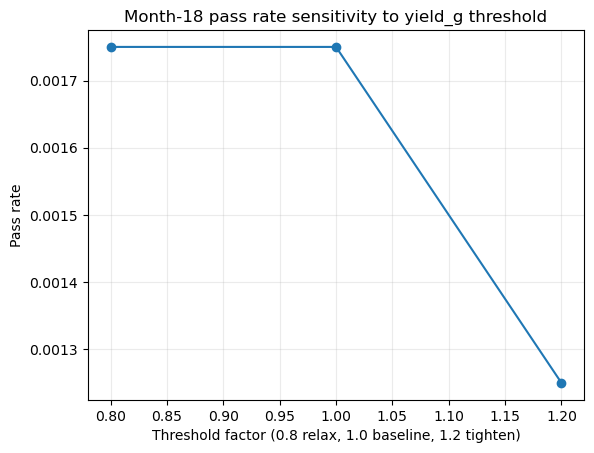

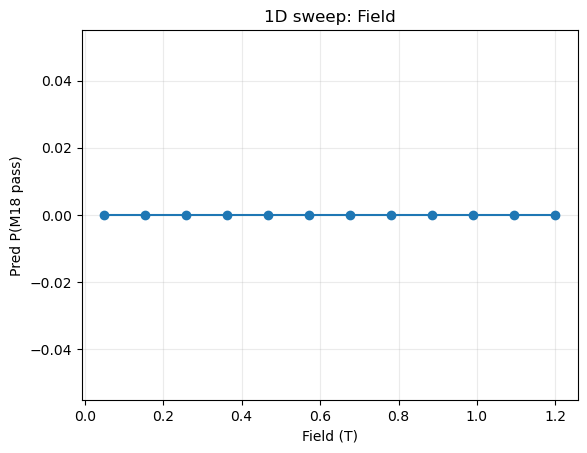

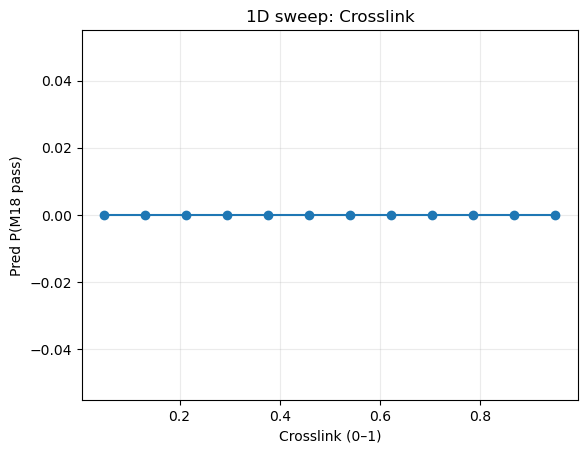

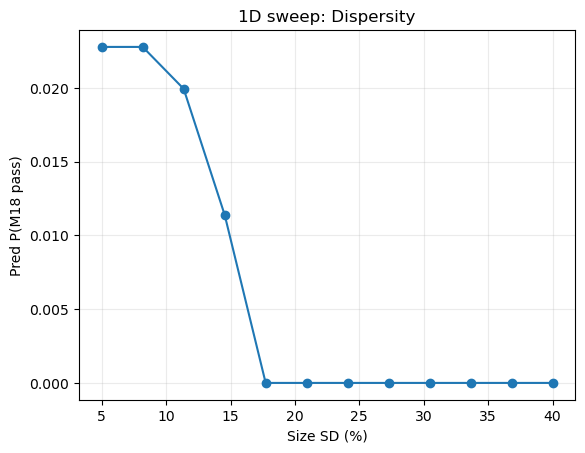


Top categorical scenarios (Month-18 probability):
            reactor         shield chelator      redox  pred_m18_prob
0       encapsulin           none     none       mild            0.0
67  ferritin_rules  protein_shell     weak  oxidizing            0.0
65  ferritin_rules  protein_shell     none   reducing            0.0
64  ferritin_rules  protein_shell     none  oxidizing            0.0
63  ferritin_rules  protein_shell     none       mild            0.0
62  ferritin_rules   peptide_thin   strong   reducing            0.0
61  ferritin_rules   peptide_thin   strong  oxidizing            0.0
60  ferritin_rules   peptide_thin   strong       mild            0.0
59  ferritin_rules   peptide_thin     weak   reducing            0.0
58  ferritin_rules   peptide_thin     weak  oxidizing            0.0
57  ferritin_rules   peptide_thin     weak       mild            0.0
56  ferritin_rules   peptide_thin     none   reducing            0.0
55  ferritin_rules   peptide_thin     none  oxidizi

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


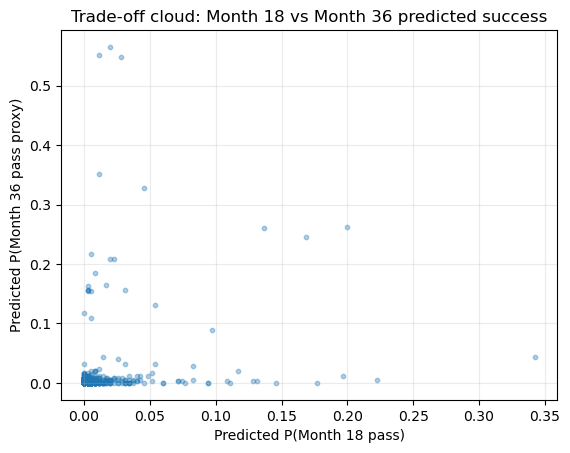


=== Evidence bundle: overall_rates ===
      n  m18_pass_rate  m36_pass_rate  median_yield_g  median_single_solid_g  \
0  4000        0.00175          0.001       11.859505               0.940818   

   median_sd_pct  median_crystalline_fraction  median_saxs_order  \
0      24.503504                     0.396501           0.606411   

   median_air_days  
0        14.290709  

=== Evidence bundle: m18_bottlenecks ===
     criterion  fail_rate_among_m18_failures
2      sd<=15%                      0.986977
4  order>=0.70                      0.763837
1    solid_g>1                      0.568244
3   cryst>0.40                      0.515402
5     air>=14d                      0.474330
0   yield_g>10                      0.318808

=== Evidence bundle: top_observed_runs ===
             reactor chelator      redox               shield  pore_gating  \
1848      encapsulin     weak       mild        protein_shell     0.711415   
331       encapsulin     none  oxidizing        protein_shell  

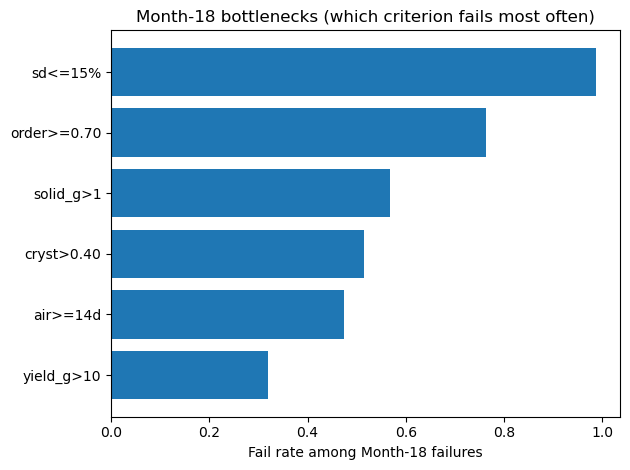

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Utilities

def _ensure_model(df: pd.DataFrame, seed: int = 7) -> Pipeline:
    """Train a Month-18 classifier quickly if not already present."""
    X = df.drop(columns=["m18_pass", "m36_pass"])
    y = df["m18_pass"]

    cat_cols = ["reactor", "chelator", "redox", "shield"]
    num_cols = [c for c in X.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ]
    )

    rf = RandomForestClassifier(
        n_estimators=350,
        random_state=seed,
        min_samples_leaf=3,
        n_jobs=-1,
        class_weight="balanced"
    )

    clf = Pipeline([("pre", pre), ("rf", rf)])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )
    clf.fit(X_train, y_train)

    proba = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, proba)
    rep = pd.DataFrame(classification_report(y_test, (proba >= 0.5).astype(int), output_dict=True)).transpose()
    rep.loc["AUC", "f1-score"] = auc
    print("\n[Month-18 model] AUC:", auc)
    return clf


def plot_sweep(xs, ys, xlabel, ylabel, title):
    plt.figure()
    plt.plot(xs, ys, marker="o", linestyle="-")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.show()

# A) Threshold stress-test

def threshold_stress_test(df: pd.DataFrame) -> pd.DataFrame:
    """
    Show how pass rate changes if you tighten/relax individual Month 18 thresholds.
    This helps communicate where the bottleneck is (yield vs order vs dispersity, etc.).
    """
    base = {
        "yield_g": 10.0,
        "single_solid_g": 1.0,
        "size_sd_pct": 15.0,
        "crystalline_fraction": 0.40,
        "saxs_order": 0.70,
        "air_stability_days": 14.0
    }

    # sweep factors: relax by 20% and tighten by 20%
    factors = [0.8, 1.0, 1.2]
    rows = []

    for metric, thr in base.items():
        for f in factors:
            t = thr * f
            # keep other thresholds at baseline
            cond = (
                (df["yield_g"] > base["yield_g"]) &
                (df["single_solid_g"] > base["single_solid_g"]) &
                (df["size_sd_pct"] <= base["size_sd_pct"]) &
                (df["crystalline_fraction"] > base["crystalline_fraction"]) &
                (df["saxs_order"] >= base["saxs_order"]) &
                (df["air_stability_days"] >= base["air_stability_days"])
            )

            # Replace the threshold for the swept metric
            if metric == "yield_g":
                cond = cond & (df["yield_g"] > t) | (cond & ~(df["yield_g"] > base["yield_g"]) & (df["yield_g"] > t))
                # simpler: recompute from scratch below
            # safer to recompute from scratch:
            cond = (
                (df["yield_g"] > (t if metric == "yield_g" else base["yield_g"])) &
                (df["single_solid_g"] > (t if metric == "single_solid_g" else base["single_solid_g"])) &
                (df["size_sd_pct"] <= (t if metric == "size_sd_pct" else base["size_sd_pct"])) &
                (df["crystalline_fraction"] > (t if metric == "crystalline_fraction" else base["crystalline_fraction"])) &
                (df["saxs_order"] >= (t if metric == "saxs_order" else base["saxs_order"])) &
                (df["air_stability_days"] >= (t if metric == "air_stability_days" else base["air_stability_days"]))
            )

            rows.append({
                "metric": metric,
                "factor": f,
                "threshold_used": t,
                "pass_rate": float(cond.mean())
            })

    out = pd.DataFrame(rows).sort_values(["metric", "factor"])
    return out

# B) Partial dependence-style sweeps (1D)

def one_dim_sweep(
    clf: Pipeline,
    template_row: pd.Series,
    var: str,
    grid: np.ndarray,
    fixed_overrides: dict | None = None
) -> pd.DataFrame:
    """
    Create a 1D sweep of a chosen variable while keeping others fixed,
    then predict Month-18 pass probability.
    """
    fixed_overrides = fixed_overrides or {}
    rows = []
    for v in grid:
        r = template_row.copy()
        r[var] = v
        for k, val in fixed_overrides.items():
            r[k] = val
        rows.append(r)

    Xs = pd.DataFrame(rows)
    # Ensure columns match model expectation
    proba = clf.predict_proba(Xs)[:, 1]
    return pd.DataFrame({var: grid, "pred_m18_prob": proba})

# C) Scenario comparison: categorical choices

def scenario_matrix(
    clf: Pipeline,
    base_row: pd.Series,
    reactors=("encapsulin", "ferritin_rules"),
    shields=("none", "peptide_thin", "protein_shell", "protein_matrix_perm", "sacrificial_matrix"),
    chelators=("none", "weak", "strong"),
    redox=("mild", "oxidizing", "reducing")
) -> pd.DataFrame:
    rows = []
    for r in reactors:
        for s in shields:
            for c in chelators:
                for rx in redox:
                    row = base_row.copy()
                    row["reactor"] = r
                    row["shield"] = s
                    row["chelator"] = c
                    row["redox"] = rx
                    rows.append(row)
    Xs = pd.DataFrame(rows)
    proba = clf.predict_proba(Xs)[:, 1]
    out = Xs[["reactor", "shield", "chelator", "redox"]].copy()
    out["pred_m18_prob"] = proba
    return out.sort_values("pred_m18_prob", ascending=False)

# D) Month-36 proxy model + dual-objective ranking

def train_month36_classifier(df: pd.DataFrame, seed: int = 7) -> Tuple[Pipeline, pd.DataFrame]:
    target = "m36_pass"
    X = df.drop(columns=["m18_pass", target])
    y = df[target]

    cat_cols = ["reactor", "chelator", "redox", "shield"]
    num_cols = [c for c in X.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ]
    )

    rf = RandomForestClassifier(
        n_estimators=350,
        random_state=seed,
        min_samples_leaf=3,
        n_jobs=-1,
        class_weight="balanced"
    )
    clf = Pipeline([("pre", pre), ("rf", rf)])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )
    clf.fit(X_train, y_train)
    proba = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, proba)
    rep = pd.DataFrame(classification_report(y_test, (proba >= 0.5).astype(int), output_dict=True)).transpose()
    rep.loc["AUC", "f1-score"] = auc
    return clf, rep


def dual_objective_rank(
    m18_clf: Pipeline,
    m36_clf: Pipeline,
    candidates: pd.DataFrame,
    w18: float = 0.6,
    w36: float = 0.4
) -> pd.DataFrame:
    """
    Rank candidates by weighted probability: w18*P(M18 pass) + w36*P(M36 pass).
    """
    X = candidates.drop(columns=["m18_pass", "m36_pass"], errors="ignore")
    candidates = candidates.copy()
    candidates["p_m18"] = m18_clf.predict_proba(X)[:, 1]
    candidates["p_m36"] = m36_clf.predict_proba(X)[:, 1]
    candidates["score"] = w18 * candidates["p_m18"] + w36 * candidates["p_m36"]
    return candidates.sort_values("score", ascending=False)

# E) Evidence bundle tables 

def evidence_bundle(df: pd.DataFrame, n_show: int = 12) -> Dict[str, pd.DataFrame]:
    """
    Produce compact evidence-style tables:
    - overall pass rates
    - bottleneck frequencies
    - best observed runs
    """
    out = {}

    out["overall_rates"] = pd.DataFrame([{
        "n": int(len(df)),
        "m18_pass_rate": float(df["m18_pass"].mean()),
        "m36_pass_rate": float(df["m36_pass"].mean()),
        "median_yield_g": float(df["yield_g"].median()),
        "median_single_solid_g": float(df["single_solid_g"].median()),
        "median_sd_pct": float(df["size_sd_pct"].median()),
        "median_crystalline_fraction": float(df["crystalline_fraction"].median()),
        "median_saxs_order": float(df["saxs_order"].median()),
        "median_air_days": float(df["air_stability_days"].median()),
    }])

    # Bottleneck analysis: which criterion fails most among failures?
    base = {
        "yield_g>10": df["yield_g"] > 10.0,
        "solid_g>1": df["single_solid_g"] > 1.0,
        "sd<=15%": df["size_sd_pct"] <= 15.0,
        "cryst>0.40": df["crystalline_fraction"] > 0.40,
        "order>=0.70": df["saxs_order"] >= 0.70,
        "air>=14d": df["air_stability_days"] >= 14.0
    }
    fail = df[df["m18_pass"] == 0].copy()
    if len(fail) > 0:
        fails = []
        for k, ok in base.items():
            fails.append({"criterion": k, "fail_rate_among_m18_failures": float((~ok.loc[fail.index]).mean())})
        out["m18_bottlenecks"] = pd.DataFrame(fails).sort_values("fail_rate_among_m18_failures", ascending=False)
    else:
        out["m18_bottlenecks"] = pd.DataFrame([{"note": "No failures in this dataset (unlikely)."}])

    # Best observed Month 18-like runs by raw criteria sum
    score = (
        (df["yield_g"] / 10.0).clip(0, 2) +
        (df["single_solid_g"] / 1.0).clip(0, 2) +
        (0.40 / df["crystalline_fraction"]).clip(0, 2) * 0.0 +  # placeholder; keep simple
        (df["crystalline_fraction"] / 0.40).clip(0, 2) +
        (df["saxs_order"] / 0.70).clip(0, 2) +
        (df["air_stability_days"] / 14.0).clip(0, 2) +
        (15.0 / df["size_sd_pct"]).clip(0, 2)
    )
    best = df.copy()
    best["raw_m18_score"] = score
    out["top_observed_runs"] = best.sort_values("raw_m18_score", ascending=False).head(n_show)

    return out

# RUN THIS (expects df and simulate_psnf_experiments exist)

if __name__ == "__main__":
    # If you ran the earlier script, df and simulate_psnf_experiments already exist.
    # Otherwise, uncomment the next 2 lines:
    # from psnf_simulator import simulate_psnf_experiments
    # df = simulate_psnf_experiments(n=4000, seed=7)

    # Train Month-18 model (or reuse)
    m18_clf = _ensure_model(df, seed=7)

    # A) Threshold stress-test
    stress = threshold_stress_test(df)
    print("\nThreshold stress-test (pass rate sensitivity):\n", stress.head(18))

    # Plot stress-test curves metric by metric
    for metric in stress["metric"].unique():
        sub = stress[stress["metric"] == metric].sort_values("factor")
        plot_sweep(
            xs=sub["factor"].values,
            ys=sub["pass_rate"].values,
            xlabel="Threshold factor (0.8 relax, 1.0 baseline, 1.2 tighten)",
            ylabel="Pass rate",
            title=f"Month-18 pass rate sensitivity to {metric} threshold"
        )

    # B) Partial dependence-style sweeps (choose a representative “base row”)
    base_row = df.drop(columns=["m18_pass", "m36_pass"]).median(numeric_only=True)
    # Add categorical defaults for the base row
    base_defaults = {
        "reactor": "encapsulin",
        "chelator": "strong",
        "redox": "oxidizing",
        "shield": "protein_shell",
    }
    # Convert base_row (numeric medians) into a full row with required columns
    base_full = pd.Series({**base_defaults, **base_row.to_dict()})
    # Ensure all columns are present
    needed_cols = df.drop(columns=["m18_pass", "m36_pass"]).columns
    base_full = base_full.reindex(needed_cols)

    # Sweep field, crosslink, and SD
    field_grid = np.linspace(0.05, 1.2, 12)
    cross_grid = np.linspace(0.05, 0.95, 12)
    sd_grid = np.linspace(5, 40, 12)

    sweep_field = one_dim_sweep(m18_clf, base_full, "field_T", field_grid)
    sweep_cross = one_dim_sweep(m18_clf, base_full, "crosslink", cross_grid)
    sweep_sd = one_dim_sweep(m18_clf, base_full, "size_sd_pct", sd_grid)

    plot_sweep(sweep_field["field_T"], sweep_field["pred_m18_prob"], "Field (T)", "Pred P(M18 pass)", "1D sweep: Field")
    plot_sweep(sweep_cross["crosslink"], sweep_cross["pred_m18_prob"], "Crosslink (0–1)", "Pred P(M18 pass)", "1D sweep: Crosslink")
    plot_sweep(sweep_sd["size_sd_pct"], sweep_sd["pred_m18_prob"], "Size SD (%)", "Pred P(M18 pass)", "1D sweep: Dispersity")

    # C) Scenario comparison matrix (categoricals)
    scen = scenario_matrix(m18_clf, base_full)
    print("\nTop categorical scenarios (Month-18 probability):\n", scen.head(15))

    # D) Month-36 proxy classifier + dual-objective ranking
    m36_clf, m36_report = train_month36_classifier(df, seed=7)
    print("\n[Month-36 model] Report (AUC stored in row 'AUC'):\n", m36_report)

    # Generate candidates and rank by dual objective
    cand = simulate_psnf_experiments(n=3000, seed=321)
    ranked_dual = dual_objective_rank(m18_clf, m36_clf, cand, w18=0.6, w36=0.4)

    print("\nTop 20 dual-objective candidate designs:\n",
          ranked_dual.head(20)[
              ["score", "p_m18", "p_m36", "reactor", "chelator", "redox", "shield",
               "field_T", "shear_s-1", "residence_s", "crosslink",
               "size_sd_pct", "crystalline_fraction", "air_stability_days",
               "yield_g", "single_solid_g", "saxs_order", "coercivity_kOe", "squareness"]
          ])

    # Visualize the Pareto-style tradeoff cloud (P(M18) vs P(M36))
    plt.figure()
    plt.scatter(ranked_dual["p_m18"], ranked_dual["p_m36"], s=10, alpha=0.35)
    plt.xlabel("Predicted P(Month 18 pass)")
    plt.ylabel("Predicted P(Month 36 pass proxy)")
    plt.title("Trade-off cloud: Month 18 vs Month 36 predicted success")
    plt.grid(True, alpha=0.25)
    plt.show()

    # E) Evidence bundle tables
    bundle = evidence_bundle(df, n_show=12)
    for name, table in bundle.items():
        print(f"\n=== Evidence bundle: {name} ===")
        print(table.head(20))

    # Optional: show bottleneck bar chart
    bott = bundle["m18_bottlenecks"].copy()
    if "criterion" in bott.columns:
        plt.figure()
        plt.barh(bott["criterion"][::-1], bott["fail_rate_among_m18_failures"][::-1])
        plt.xlabel("Fail rate among Month-18 failures")
        plt.title("Month-18 bottlenecks (which criterion fails most often)")
        plt.tight_layout()
        plt.show()

# figures + uncertainty + DOE
## Adds:
- calibrated probability (reliability curve)
- bootstrap uncertainty bands for key plots
- DOE-like “first experiments” proposal (screening design)
- SHAP-like explanation without extra dependencies (tree path + simple ICE)
- export of key tables to CSV

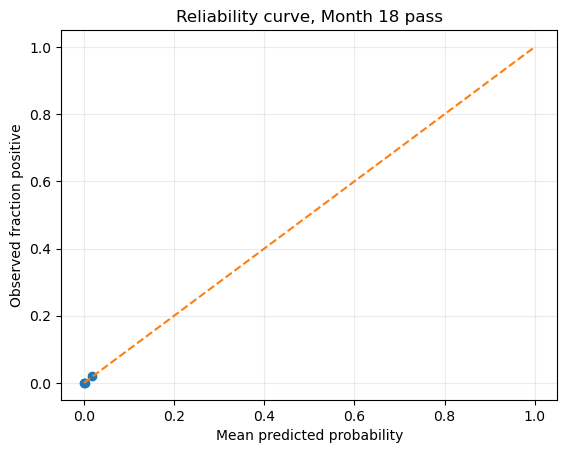


Reliability table:
    mean_pred  frac_pos
0   0.000000  0.000000
1   0.002845  0.000000
2   0.017993  0.020619


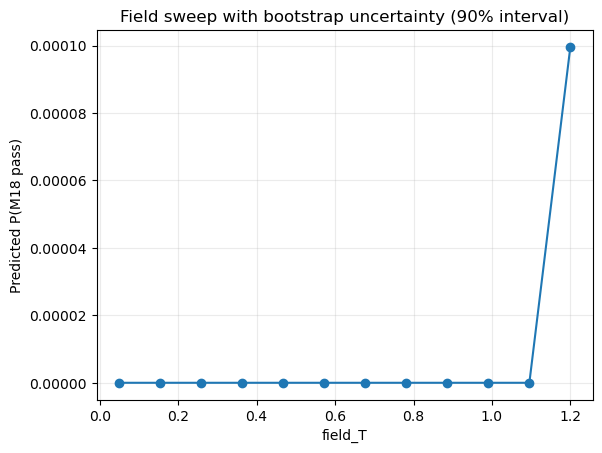


Bootstrap sweep band:
      field_T    mean  p05  p95
0   0.050000  0.0000  0.0  0.0
1   0.154545  0.0000  0.0  0.0
2   0.259091  0.0000  0.0  0.0
3   0.363636  0.0000  0.0  0.0
4   0.468182  0.0000  0.0  0.0
5   0.572727  0.0000  0.0  0.0
6   0.677273  0.0000  0.0  0.0
7   0.781818  0.0000  0.0  0.0
8   0.886364  0.0000  0.0  0.0
9   0.990909  0.0000  0.0  0.0
10  1.095455  0.0000  0.0  0.0
11  1.200000  0.0001  0.0  0.0

Proposed screening DOE (first experiments):
     pred_m18_prob         reactor chelator      redox               shield  \
0             0.0      encapsulin     none       mild         peptide_thin   
1             0.0      encapsulin     none       mild        protein_shell   
69            0.0  ferritin_rules   strong   reducing        protein_shell   
70            0.0  ferritin_rules   strong   reducing  protein_matrix_perm   
64            0.0  ferritin_rules   strong  oxidizing         peptide_thin   
55            0.0  ferritin_rules     weak  oxidizing   sac

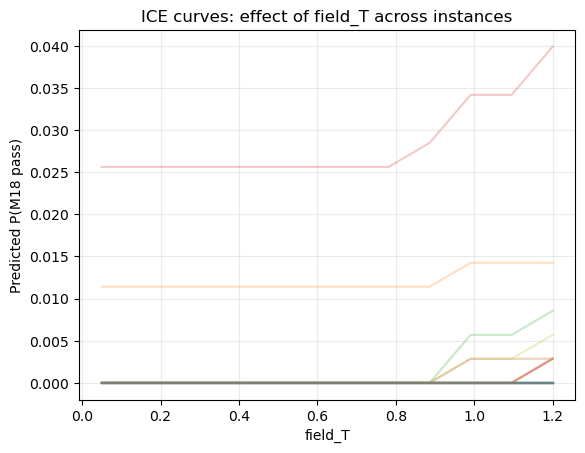

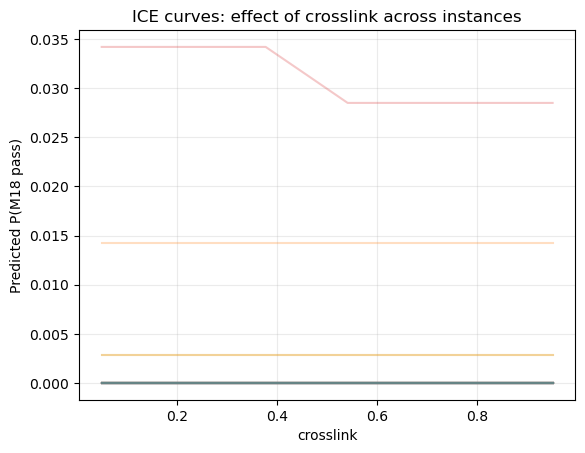

Wrote psnf_outputs/reliability_curve.csv
Wrote psnf_outputs/bootstrap_field_sweep_band.csv
Wrote psnf_outputs/proposed_screening_doe.csv

Output files:
 ['reliability_curve.csv', 'proposed_screening_doe.csv', 'bootstrap_field_sweep_band.csv']


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# A) Probability calibration (reliability)

def reliability_plot(clf: Pipeline, df: pd.DataFrame, n_bins: int = 10, seed: int = 7) -> pd.DataFrame:
    X = df.drop(columns=["m18_pass", "m36_pass"])
    y = df["m18_pass"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )
    clf.fit(X_train, y_train)
    proba = clf.predict_proba(X_test)[:, 1]

    frac_pos, mean_pred = calibration_curve(y_test, proba, n_bins=n_bins, strategy="quantile")

    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o", linestyle="-")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Observed fraction positive")
    plt.title("Reliability curve, Month 18 pass")
    plt.grid(True, alpha=0.25)
    plt.show()

    out = pd.DataFrame({"mean_pred": mean_pred, "frac_pos": frac_pos})
    return out

# B) Bootstrap uncertainty bands for a 1D sweep

def bootstrap_sweep_uncertainty(
    df: pd.DataFrame,
    base_full: pd.Series,
    var: str,
    grid: np.ndarray,
    n_boot: int = 50,
    seed: int = 7
) -> pd.DataFrame:
    """
    Bootstrap train the model and compute sweep curves to estimate uncertainty.
    Returns mean and 90% interval at each grid point.
    """
    rng = np.random.default_rng(seed)
    curves = []

    for b in range(n_boot):
        idx = rng.integers(0, len(df), size=len(df))
        dfb = df.iloc[idx].reset_index(drop=True)

        # train on bootstrap sample
        X = dfb.drop(columns=["m18_pass", "m36_pass"])
        y = dfb["m18_pass"]

        cat_cols = ["reactor", "chelator", "redox", "shield"]
        num_cols = [c for c in X.columns if c not in cat_cols]

        pre = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
                ("num", "passthrough", num_cols),
            ]
        )

        rf = RandomForestClassifier(
            n_estimators=250,
            random_state=seed + b,
            min_samples_leaf=3,
            n_jobs=-1,
            class_weight="balanced"
        )

        clf = Pipeline([("pre", pre), ("rf", rf)])
        clf.fit(X, y)

        # sweep
        rows = []
        for v in grid:
            r = base_full.copy()
            r[var] = v
            rows.append(r)

        Xs = pd.DataFrame(rows)
        p = clf.predict_proba(Xs)[:, 1]
        curves.append(p)

    curves = np.vstack(curves)  # (n_boot, len(grid))
    mean = curves.mean(axis=0)
    lo = np.quantile(curves, 0.05, axis=0)
    hi = np.quantile(curves, 0.95, axis=0)

    out = pd.DataFrame({var: grid, "mean": mean, "p05": lo, "p95": hi})
    return out


def plot_uncertainty_band(df_band: pd.DataFrame, var: str, title: str):
    plt.figure()
    plt.plot(df_band[var], df_band["mean"], marker="o", linestyle="-")
    plt.fill_between(df_band[var], df_band["p05"], df_band["p95"], alpha=0.2)
    plt.xlabel(var)
    plt.ylabel("Predicted P(M18 pass)")
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.show()

# C) DOE-like “first experiments” screening design

def propose_screening_doe(
    df: pd.DataFrame,
    m18_clf: Pipeline,
    n_rows: int = 24,
    seed: int = 11
) -> pd.DataFrame:
    """
    Create a balanced screening design:
    - evenly covers categorical choices (reactor, chelator, redox, shield)
    - spans field/shear/crosslink across low/mid/high
    - ranks by predicted probability, but keeps coverage diversity
    """
    rng = np.random.default_rng(seed)

    reactors = ["encapsulin", "ferritin_rules"]
    chelators = ["none", "weak", "strong"]
    redoxes = ["mild", "oxidizing", "reducing"]
    shields = ["peptide_thin", "protein_shell", "protein_matrix_perm", "sacrificial_matrix"]

    # choose 3 levels for continuous knobs
    field_levels = [0.15, 0.45, 0.90]
    shear_levels = [60, 150, 400]
    cross_levels = [0.20, 0.50, 0.80]
    residence_levels = [15, 45, 90]

    # start from a numeric-median template
    base = df.drop(columns=["m18_pass", "m36_pass"]).median(numeric_only=True).to_dict()

    rows = []
    for r in reactors:
        for c in chelators:
            for rx in redoxes:
                for s in shields:
                    row = base.copy()
                    row.update({
                        "reactor": r,
                        "chelator": c,
                        "redox": rx,
                        "shield": s,
                        "field_T": float(rng.choice(field_levels)),
                        "shear_s-1": float(rng.choice(shear_levels)),
                        "crosslink": float(rng.choice(cross_levels)),
                        "residence_s": float(rng.choice(residence_levels)),
                    })
                    rows.append(row)

    design = pd.DataFrame(rows)
    X = design[df.drop(columns=["m18_pass", "m36_pass"]).columns]
    design["pred_m18_prob"] = m18_clf.predict_proba(X)[:, 1]

    # keep top per shield to maintain diversity
    out = (design.sort_values("pred_m18_prob", ascending=False)
           .groupby(["shield"])
           .head(max(3, n_rows // len(shields)))
           .sort_values("pred_m18_prob", ascending=False)
           .head(n_rows))
    return out

# D) “SHAP-like” explanation without SHAP: ICE curves + tree voting

def ice_curve(
    clf: Pipeline,
    df: pd.DataFrame,
    var: str,
    grid: np.ndarray,
    n_instances: int = 40,
    seed: int = 7
) -> pd.DataFrame:
    """
    Individual Conditional Expectation: sweep var across grid for a sample of instances.
    Returns long-form table for plotting.
    """
    rng = np.random.default_rng(seed)
    X = df.drop(columns=["m18_pass", "m36_pass"]).copy()

    idx = rng.choice(len(X), size=min(n_instances, len(X)), replace=False)
    Xs = X.iloc[idx].reset_index(drop=True)

    rows = []
    for i in range(len(Xs)):
        row0 = Xs.iloc[i].copy()
        for v in grid:
            row = row0.copy()
            row[var] = v
            p = clf.predict_proba(pd.DataFrame([row]))[:, 1][0]
            rows.append({"instance": i, var: v, "pred": p})

    return pd.DataFrame(rows)


def plot_ice(df_ice: pd.DataFrame, var: str, title: str):
    plt.figure()
    for inst in df_ice["instance"].unique():
        sub = df_ice[df_ice["instance"] == inst]
        plt.plot(sub[var], sub["pred"], alpha=0.25)
    plt.xlabel(var)
    plt.ylabel("Predicted P(M18 pass)")
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.show()

# E) Export key tables to CSV

def export_tables(outdir: str, tables: dict):
    import os
    os.makedirs(outdir, exist_ok=True)
    for name, df_t in tables.items():
        path = os.path.join(outdir, f"{name}.csv")
        df_t.to_csv(path, index=False)
        print("Wrote", path)

# RUN THIS (expects df and m18_clf exist)

if __name__ == "__main__":
    # If needed, train a fresh Month-18 model here:
    # m18_clf = _ensure_model(df, seed=7)

    # A) reliability curve
    rel = reliability_plot(m18_clf, df, n_bins=10, seed=7)
    print("\nReliability table:\n", rel)

    # Build base_full if not already built
    needed_cols = df.drop(columns=["m18_pass", "m36_pass"]).columns
    base_row = df.drop(columns=["m18_pass", "m36_pass"]).median(numeric_only=True)
    base_defaults = {"reactor": "encapsulin", "chelator": "strong", "redox": "oxidizing", "shield": "protein_shell"}
    base_full = pd.Series({**base_defaults, **base_row.to_dict()}).reindex(needed_cols)

    # B) bootstrap uncertainty band for field sweep
    field_grid = np.linspace(0.05, 1.2, 12)
    band = bootstrap_sweep_uncertainty(df, base_full, "field_T", field_grid, n_boot=40, seed=7)
    plot_uncertainty_band(band, "field_T", "Field sweep with bootstrap uncertainty (90% interval)")
    print("\nBootstrap sweep band:\n", band)

    # C) DOE screening design proposal (first 24 experiments)
    doe = propose_screening_doe(df, m18_clf, n_rows=24, seed=11)
    print("\nProposed screening DOE (first experiments):\n",
          doe[["pred_m18_prob", "reactor", "chelator", "redox", "shield",
               "field_T", "shear_s-1", "residence_s", "crosslink"]].head(24))

    # D) ICE curves for field and crosslink
    ice_field = ice_curve(m18_clf, df, "field_T", field_grid, n_instances=35, seed=9)
    plot_ice(ice_field, "field_T", "ICE curves: effect of field_T across instances")

    cross_grid = np.linspace(0.05, 0.95, 12)
    ice_cross = ice_curve(m18_clf, df, "crosslink", cross_grid, n_instances=35, seed=9)
    plot_ice(ice_cross, "crosslink", "ICE curves: effect of crosslink across instances")

    # E) Export key tables
    tables = {
        "reliability_curve": rel,
        "bootstrap_field_sweep_band": band,
        "proposed_screening_doe": doe
    }
    export_tables("psnf_outputs", tables)

    # Optional: quick view of output directory listing
    import os
    print("\nOutput files:\n", os.listdir("psnf_outputs"))

# physics-inspired BHmax proxy + multi-objective
## Adds:
- density / packing fraction model
- saturation magnetization (Ms) proxy by phase + crystallinity + oxidation
- BHmax proxy (MGOe) from (Br, Hc) approximations
- constraint-aware multi-objective search (NSGA-II style, lightweight)
- Pareto front visualization + “top feasible” recommendations

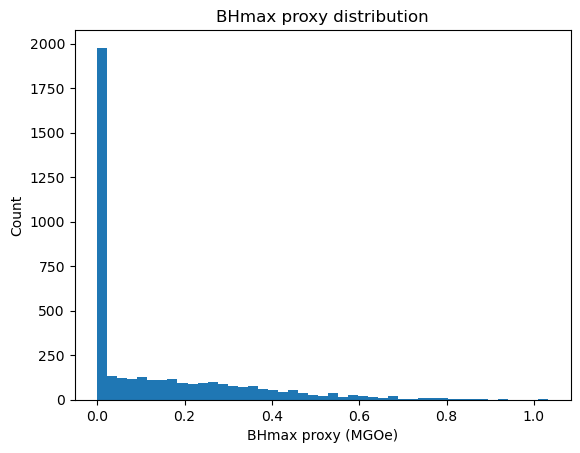

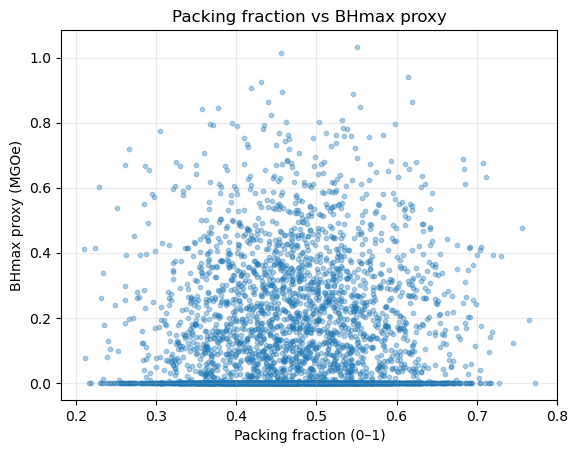


Feasible designs (meet M18 + functional proxy + BHmax): 0
Pareto-optimal designs: 0

Wrote psnf_outputs/pareto_optimal_designs.csv and psnf_outputs/feasible_designs.csv


In [7]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Tuple, Dict

# A) Extend simulator outputs: density, Ms, Br, BHmax

@dataclass
class MagnetSpecs:
    # Targets inspired by ARIA TA1.3 exemplar table language, but modeled as proxies here.
    squareness_min: float = 0.80
    coercivity_kOe_min: float = 1.00
    bhmax_mgoe_min: float = 3.0  # proxy threshold, adjust for your narrative


def add_physics_proxies(df: pd.DataFrame, seed: int = 7) -> pd.DataFrame:
    """
    Add additional “physics-inspired” proxies:
    - packing_fraction (0..1): improves with sacrificial/permanent matrices + order, penalized by SD and thick shields
    - density_g_cm3: packing_fraction * intrinsic_density_proxy
    - Ms_emu_g: saturation magnetization proxy based on phase, crystallinity, oxidation risk
    - Br_kG: remanence proxy derived from Ms and squareness
    - BHmax_MGOe: energy product proxy derived from Br and Hc

    These are not claims about real performance, they provide a consistent quantitative scaffold
    for multi-objective ranking and feasibility checks.
    """
    rng = np.random.default_rng(seed)
    out = df.copy()

    # Intrinsic density proxy by “phase family”
    # In a real project: replace with literature-based densities per candidate phase.
    # Here: tie to reactor choice as a placeholder “phase module”
    intrinsic_density = np.where(out["reactor"] == "ferritin_rules", 5.2, 4.8)  # g/cm^3 proxy
    intrinsic_density += rng.normal(0, 0.08, size=len(out))

    # Shield penalty on packing (protein_shell tends to be thin, matrices can be removed or densified)
    shield_pack_penalty = np.select(
        [
            out["shield"] == "none",
            out["shield"] == "peptide_thin",
            out["shield"] == "protein_shell",
            out["shield"] == "protein_matrix_perm",
            out["shield"] == "sacrificial_matrix"
        ],
        [0.05, 0.02, 0.03, 0.04, 0.02]
    )

    # Packing fraction driven by order + crosslink + shield choice, penalized by dispersity
    packing = (
        0.35
        + 0.35 * out["saxs_order"]
        + 0.10 * (out["shield"] == "sacrificial_matrix").astype(float)
        + 0.08 * (out["shield"] == "protein_matrix_perm").astype(float)
        + 0.08 * (out["crosslink"] > 0.6).astype(float)
        - 0.005 * out["size_sd_pct"]
        - shield_pack_penalty
        + rng.normal(0, 0.04, size=len(out))
    )
    packing = np.clip(packing, 0.10, 0.85)

    density = packing * intrinsic_density
    density = np.clip(density, 0.2, 6.5)

    # Oxidation risk proxy (already used before)
    oxidation_risk = 1.0 / (1.0 + np.exp(-(10.0 - out["air_stability_days"]) / 3.5))

    # Ms proxy (emu/g): increases with crystallinity and decreases with oxidation risk and thick shielding/low packing
    # In a real version: make phase-specific Ms priors (e.g., ferrites vs nitrides)
    ms_base = np.where(out["reactor"] == "ferritin_rules", 75.0, 62.0)  # emu/g proxy
    Ms_emu_g = (
        ms_base
        + 35.0 * (out["crystalline_fraction"] - 0.4)
        + 10.0 * (out["saxs_order"] - 0.6)
        + 12.0 * (packing - 0.5)
        - 25.0 * oxidation_risk
        + rng.normal(0, 6.0, size=len(out))
    )
    Ms_emu_g = np.clip(Ms_emu_g, 5.0, 140.0)

    # Remanence Br proxy: Br ≈ Ms * squareness * packing scaling (convert to kG proxy)
    # We keep it as kG-like units for the BHmax proxy formula.
    Br_kG = 0.01 * Ms_emu_g * out["squareness"] * (0.7 + 0.6 * packing)  # scaling factor for proxy units
    Br_kG = np.clip(Br_kG, 0.01, 20.0)

    # Coercivity already in kOe. Convert to kOe proxy directly.
    Hc_kOe = out["coercivity_kOe"].values

    # BHmax proxy (MGOe): use a rough proportional relation:
    # BHmax ∝ Br^2 (for reasonably square loops), with moderation by coercivity and packing.
    # This is a toy model for ranking only.
    BHmax_MGOe = (
        0.35 * (Br_kG ** 2) * np.tanh(Hc_kOe / 2.0) * (0.6 + 0.8 * packing)
        + rng.normal(0, 0.3, size=len(out))
    )
    BHmax_MGOe = np.clip(BHmax_MGOe, 0.0, 30.0)

    out["packing_fraction"] = packing
    out["density_g_cm3"] = density
    out["Ms_emu_g"] = Ms_emu_g
    out["Br_kG"] = Br_kG
    out["BHmax_MGOe"] = BHmax_MGOe

    return out

# B) Multi-objective ranking with constraints (light NSGA-II-ish)

def dominates(a: np.ndarray, b: np.ndarray) -> bool:
    """
    Return True if a dominates b (minimization for all objectives).
    """
    return np.all(a <= b) and np.any(a < b)


def pareto_front(points: np.ndarray) -> np.ndarray:
    """
    Compute boolean mask for Pareto-optimal points (minimize all objectives).
    """
    n = points.shape[0]
    is_pareto = np.ones(n, dtype=bool)
    for i in range(n):
        if not is_pareto[i]:
            continue
        for j in range(n):
            if i == j or not is_pareto[j]:
                continue
            if dominates(points[j], points[i]):
                is_pareto[i] = False
                break
    return is_pareto


def multiobjective_select(
    df: pd.DataFrame,
    specs: MagnetSpecs | None = None,
    require_m18: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Select candidates using three objectives (maximize):
      - P(M18 pass)   (or hard m18_pass if require_m18 True)
      - P(M36 pass)   (or hard m36_pass)
      - BHmax proxy

    We convert to minimization by using negative values.
    Returns: (pareto_df, feasible_df)
    """
    if specs is None:
        specs = MagnetSpecs()

    d = df.copy()

    # Feasibility constraints (hard)
    feasible = np.ones(len(d), dtype=bool)
    if require_m18:
        feasible &= (d["m18_pass"] == 1)
    # functional constraints proxy
    feasible &= (d["squareness"] >= specs.squareness_min)
    feasible &= (d["coercivity_kOe"] >= specs.coercivity_kOe_min)
    feasible &= (d["BHmax_MGOe"] >= specs.bhmax_mgoe_min)

    feasible_df = d[feasible].copy()

    if len(feasible_df) == 0:
        return feasible_df, feasible_df

    # Objectives: maximize (BHmax, squareness, coercivity) while also favoring throughput and order
    # Convert to minimization for Pareto.
    # We use 4 objectives to give the Pareto front structure:
    #   1) -BHmax
    #   2) -squareness
    #   3) -coercivity
    #   4) -saxs_order
    obj = np.column_stack([
        -feasible_df["BHmax_MGOe"].values,
        -feasible_df["squareness"].values,
        -feasible_df["coercivity_kOe"].values,
        -feasible_df["saxs_order"].values,
    ])

    mask = pareto_front(obj)
    pareto_df = feasible_df[mask].copy().sort_values(["BHmax_MGOe", "squareness", "coercivity_kOe"], ascending=False)

    return pareto_df, feasible_df

# C) Visualization helpers for Pareto front

def plot_pareto_cloud(feasible_df: pd.DataFrame, pareto_df: pd.DataFrame) -> None:
    plt.figure()
    plt.scatter(feasible_df["BHmax_MGOe"], feasible_df["coercivity_kOe"], s=12, alpha=0.25)
    if len(pareto_df) > 0:
        plt.scatter(pareto_df["BHmax_MGOe"], pareto_df["coercivity_kOe"], s=30, alpha=0.9)
    plt.xlabel("BHmax proxy (MGOe)")
    plt.ylabel("Coercivity (kOe)")
    plt.title("Feasible designs (cloud) and Pareto-optimal subset (highlighted)")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure()
    plt.scatter(feasible_df["BHmax_MGOe"], feasible_df["squareness"], s=12, alpha=0.25)
    if len(pareto_df) > 0:
        plt.scatter(pareto_df["BHmax_MGOe"], pareto_df["squareness"], s=30, alpha=0.9)
    plt.xlabel("BHmax proxy (MGOe)")
    plt.ylabel("Squareness (0–1)")
    plt.title("BHmax vs squareness, Pareto highlighted")
    plt.grid(True, alpha=0.25)
    plt.show()

# D) Run 

if __name__ == "__main__":
    # Assumes you have df from earlier simulation.
    # If not, uncomment the next line:
    # df = simulate_psnf_experiments(n=6000, seed=7)

    df2 = add_physics_proxies(df, seed=7)

    # Quick dataset visuals
    plt.figure()
    plt.hist(df2["BHmax_MGOe"], bins=45)
    plt.xlabel("BHmax proxy (MGOe)")
    plt.ylabel("Count")
    plt.title("BHmax proxy distribution")
    plt.show()

    plt.figure()
    plt.scatter(df2["packing_fraction"], df2["BHmax_MGOe"], s=10, alpha=0.35)
    plt.xlabel("Packing fraction (0–1)")
    plt.ylabel("BHmax proxy (MGOe)")
    plt.title("Packing fraction vs BHmax proxy")
    plt.grid(True, alpha=0.25)
    plt.show()

    # Multi-objective selection
    specs = MagnetSpecs(squareness_min=0.80, coercivity_kOe_min=1.00, bhmax_mgoe_min=3.0)
    pareto_df, feasible_df = multiobjective_select(df2, specs=specs, require_m18=True)

    print("\nFeasible designs (meet M18 + functional proxy + BHmax):", len(feasible_df))
    print("Pareto-optimal designs:", len(pareto_df))

    # Show top Pareto recommendations
    if len(pareto_df) > 0:
        cols = [
            "BHmax_MGOe", "squareness", "coercivity_kOe",
            "reactor", "chelator", "redox", "shield",
            "field_T", "shear_s-1", "residence_s", "crosslink",
            "packing_fraction", "density_g_cm3", "Ms_emu_g", "Br_kG",
            "yield_g", "single_solid_g", "size_sd_pct", "crystalline_fraction",
            "air_stability_days", "saxs_order"
        ]
        print("\nTop 15 Pareto-optimal designs:\n", pareto_df[cols].head(15))

    # Plot Pareto cloud
    if len(feasible_df) > 0:
        plot_pareto_cloud(feasible_df, pareto_df)

    # Optional: export
    pareto_df.to_csv("psnf_outputs/pareto_optimal_designs.csv", index=False)
    feasible_df.to_csv("psnf_outputs/feasible_designs.csv", index=False)
    print("\nWrote psnf_outputs/pareto_optimal_designs.csv and psnf_outputs/feasible_designs.csv")

# intensive + extensive analysis toolkit
## Adds:
1) rigorous CV evaluation + PR curve + confusion matrices
2) interaction analysis (2D response surfaces) for key knobs
3) ablation studies (remove feature groups, quantify AUC drop)
4) counterfactual “what-if” policies (optimize one knob at a time)
5) uplift-style analysis (treatment effect of shield / chelator)
6) unsupervised structure (PCA on numerics) + cluster signatures
7) failure-mode taxonomy (which criteria fail most, by subgroup)


CV evaluation:
    fold       AUC        AP  pos_rate
0     1  0.993742  0.166667   0.00125
1     2  1.000000  1.000000   0.00125
2     3  1.000000  1.000000   0.00125
3     4  1.000000  1.000000   0.00250
4     5  1.000000  1.000000   0.00250

CV mean AUC: 0.9987484355444305 ± 0.0027985832008758267
CV mean AP: 0.8333333333333334 ± 0.372677996249965


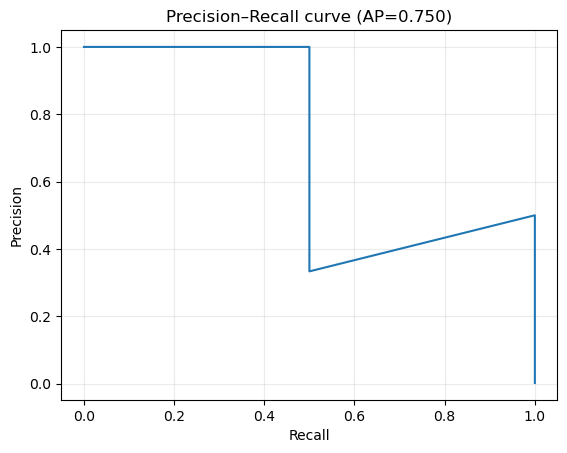

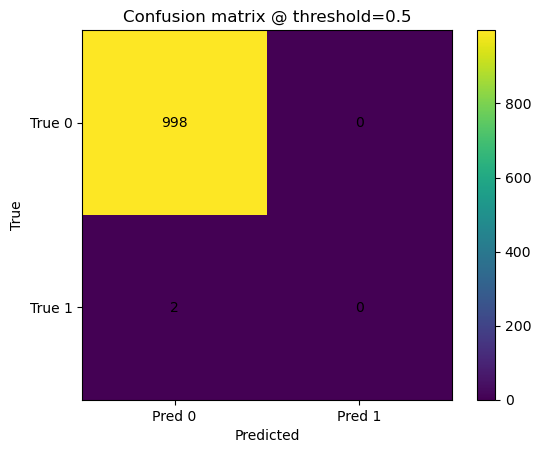

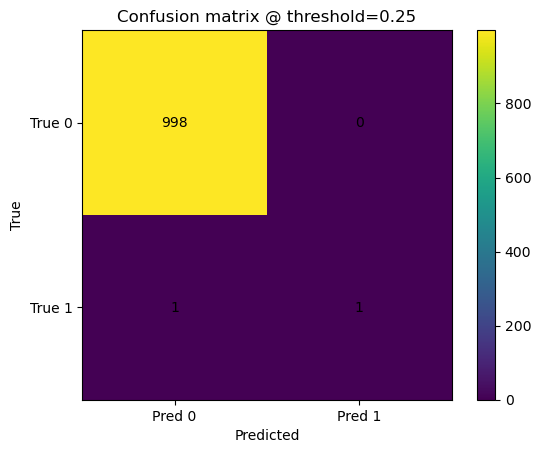

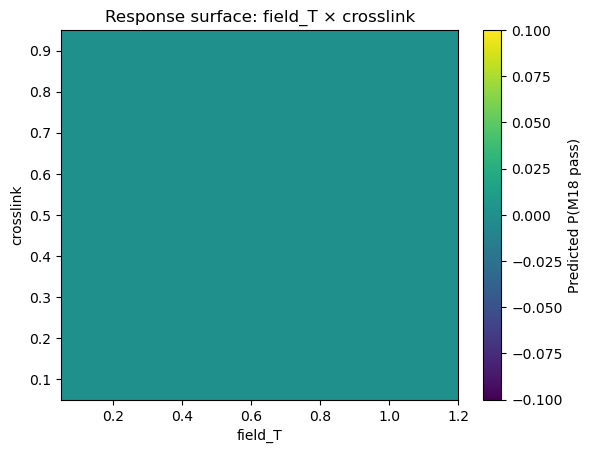

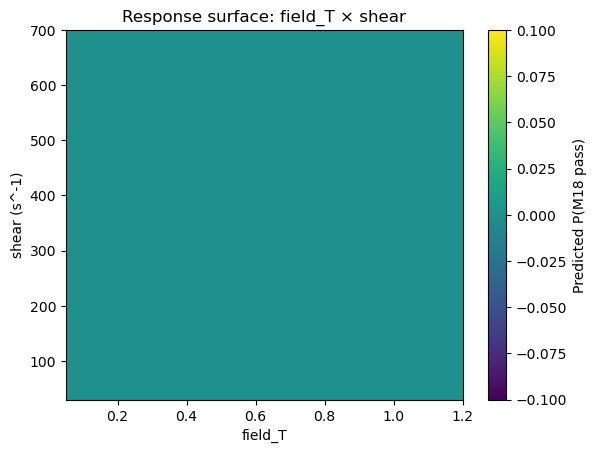


Ablation AUC drops:
                     group       auc  auc_drop
4   DROP_OBSERVED_METRICS  0.664579  0.334419
0            ALL_FEATURES  0.998998  0.000000
1  DROP_REACTOR_CHEMISTRY  0.999499 -0.000501
2      DROP_SHIELD_LOCKIN  0.999499 -0.000501
3         DROP_FIELD_FLOW  0.999499 -0.000501


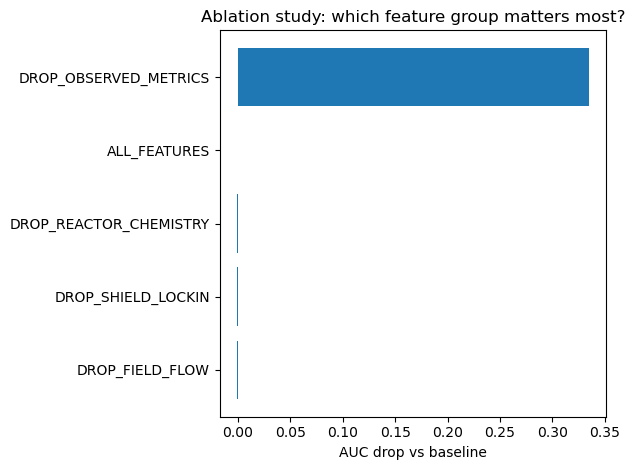


Counterfactual uplift by optimizing field:
         baseline_p       best_p       uplift  best_field_T
count  4000.000000  4000.000000  4000.000000   4000.000000
mean      0.002254     0.003044     0.000790      0.282608
std       0.031318     0.031854     0.003240      0.443676
min       0.000000     0.000000    -0.002222      0.050000
25%       0.000000     0.000000     0.000000      0.050000
50%       0.000000     0.000000     0.000000      0.050000
75%       0.000000     0.000000     0.000000      0.050000
max       0.799247     0.797051     0.057723      1.200000


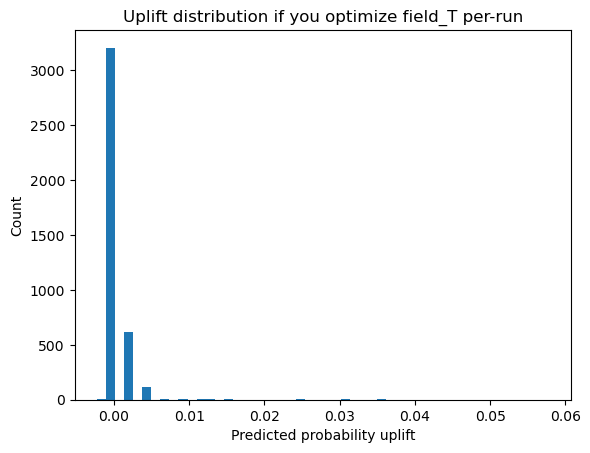


Counterfactual uplift by optimizing crosslink:
         baseline_p       best_p       uplift  best_crosslink
count  4000.000000  4000.000000  4000.000000     4000.000000
mean      0.002254     0.004499     0.002245        0.547491
std       0.031318     0.031494     0.000984        0.091638
min       0.000000     0.000000    -0.002249        0.050000
25%       0.000000     0.002191     0.002191        0.564286
50%       0.000000     0.002191     0.002191        0.564286
75%       0.000000     0.002191     0.002191        0.564286
max       0.799247     0.805932     0.022190        0.628571


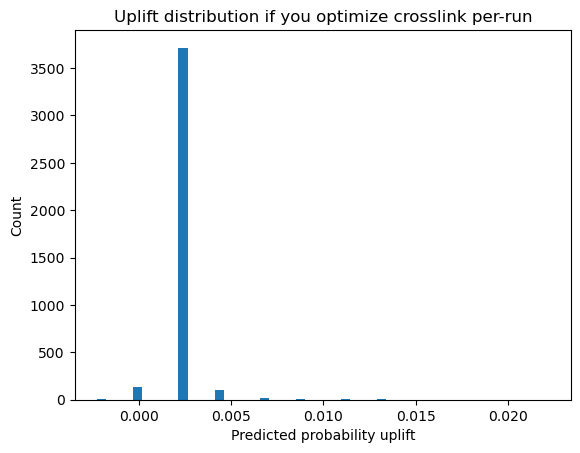


Shield uplift (peptide_thin -> protein_shell):
         p_baseline  p_treatment       uplift
count  4000.000000  4000.000000  4000.000000
mean      0.002199     0.002132    -0.000066
std       0.030411     0.029607     0.001025
min       0.000000     0.000000    -0.035437
25%       0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000
max       0.774662     0.752528     0.004447


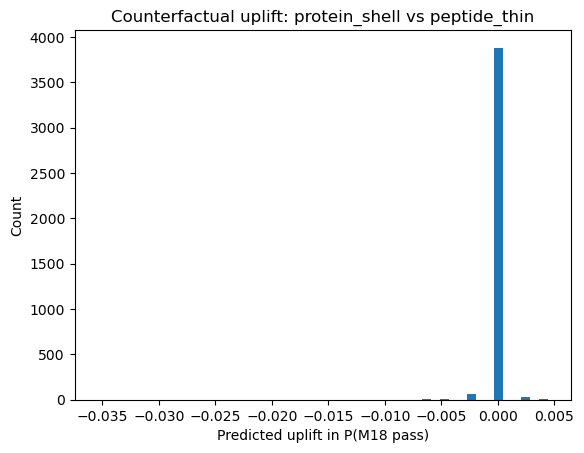


Cluster summary (medians + pass rates):
    cluster  pore_gating  luminal_charge  cargo_loading  phosphorus_free  \
5        5    -0.126425        0.142262       0.609707              1.0   
0        0    -0.177077        0.189769       0.564074              0.0   
1        1    -0.067586       -0.012680       0.621715              1.0   
2        2     0.099722       -0.098736       0.585750              0.0   
3        3    -0.053162       -0.345813       0.639444              0.0   
4        4     0.197271        0.052883       0.635790              0.0   

   feed_rate  crosslink   field_T   shear_s-1  residence_s  ...  size_sd_pct  \
5   0.933099   0.541953  0.876130  164.949661    69.075701  ...    22.560645   
0   0.867120   0.546903  0.923787  200.176997    76.271351  ...    22.244087   
1   0.904221   0.466814  0.286010  147.063402    62.121410  ...    24.230038   
2   1.035005   0.452327  0.245518  112.610343    56.816254  ...    26.272808   
3   1.596230   0.500919  0.79073

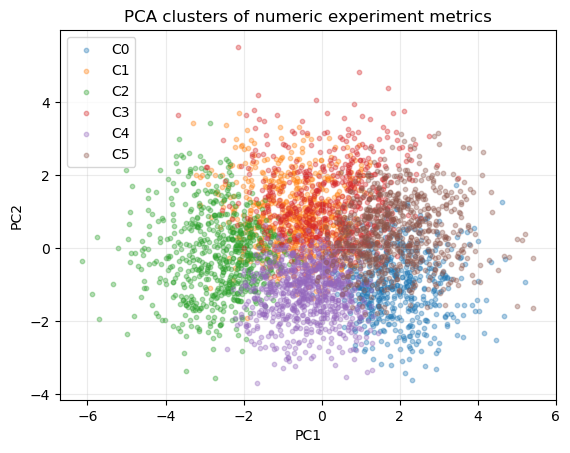


Failure-mode taxonomy by shield × reactor:
                 shield         reactor  n_fail  fail_yield  fail_solid  \
4  protein_matrix_perm      encapsulin     662    0.287009    0.225076   
2         peptide_thin      encapsulin     638    0.271160    0.793103   
6        protein_shell      encapsulin     521    0.284069    0.786948   
8   sacrificial_matrix      encapsulin     507    0.297830    0.384615   
5  protein_matrix_perm  ferritin_rules     357    0.313725    0.246499   
3         peptide_thin  ferritin_rules     348    0.284483    0.798851   
9   sacrificial_matrix  ferritin_rules     292    0.294521    0.369863   
7        protein_shell  ferritin_rules     283    0.303887    0.802120   
0                 none      encapsulin     250    0.604000    0.788000   
1                 none  ferritin_rules     135    0.570370    0.822222   

    fail_sd  fail_cryst  fail_order  fail_air  
4  0.990937    0.548338    0.777946  0.368580  
2  0.974922    0.503135    0.666144  0.66300

In [13]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 0) Shared model builder

def build_rf_pipeline(seed: int = 7) -> Pipeline:
    cat_cols = ["reactor", "chelator", "redox", "shield"]
    # note: the pipeline will discover numeric columns at fit time, we pass indices via ColumnTransformer below

    def make_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
        cat_cols_local = [c for c in cat_cols if c in X.columns]
        num_cols_local = [c for c in X.columns if c not in cat_cols_local]

        return ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_local),
                ("num", "passthrough", num_cols_local),
            ],
            remainder="drop"
        )

    # We wrap preprocessor creation inside a function, but sklearn wants a fixed transformer.
    # So we set it later, after we see X columns.
    # We'll keep a placeholder and patch at runtime in training functions.
    rf = RandomForestClassifier(
        n_estimators=450,
        random_state=seed,
        min_samples_leaf=3,
        n_jobs=-1,
        class_weight="balanced"
    )
    # placeholder pre; set later
    pre = ColumnTransformer([("passthrough", "passthrough", [])])
    return Pipeline([("pre", pre), ("rf", rf)])


def set_preprocessor(clf: Pipeline, X: pd.DataFrame) -> Pipeline:
    cat_cols = ["reactor", "chelator", "redox", "shield"]
    cat_cols = [c for c in cat_cols if c in X.columns]
    num_cols = [c for c in X.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ]
    )
    clf = Pipeline([("pre", pre), ("rf", clf.named_steps["rf"])])
    return clf

# 1) Rigorous cross-validation evaluation

def cv_evaluate_m18(df: pd.DataFrame, n_splits: int = 5, seed: int = 7) -> pd.DataFrame:
    X = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore")
    y = df["m18_pass"].values

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    rows = []

    for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y[tr], y[te]

        clf = build_rf_pipeline(seed + fold)
        clf = set_preprocessor(clf, Xtr)
        clf.fit(Xtr, ytr)

        p = clf.predict_proba(Xte)[:, 1]
        auc = roc_auc_score(yte, p)
        ap = average_precision_score(yte, p)

        rows.append({"fold": fold, "AUC": auc, "AP": ap, "pos_rate": float(yte.mean())})

    out = pd.DataFrame(rows)
    return out


def plot_pr_curve(df: pd.DataFrame, clf: Pipeline, seed: int = 7) -> None:
    X = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore")
    y = df["m18_pass"].values

    # holdout
    idx = np.arange(len(df))
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    split = int(0.75 * len(df))
    tr, te = idx[:split], idx[split:]

    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = y[tr], y[te]

    clf = set_preprocessor(clf, Xtr)
    clf.fit(Xtr, ytr)
    p = clf.predict_proba(Xte)[:, 1]

    prec, rec, thr = precision_recall_curve(yte, p)
    ap = average_precision_score(yte, p)

    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall curve (AP={ap:.3f})")
    plt.grid(True, alpha=0.25)
    plt.show()


def plot_confusion_at_threshold(df: pd.DataFrame, clf: Pipeline, threshold: float = 0.5, seed: int = 7) -> None:
    X = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore")
    y = df["m18_pass"].values

    # holdout
    idx = np.arange(len(df))
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    split = int(0.75 * len(df))
    tr, te = idx[:split], idx[split:]

    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = y[tr], y[te]

    clf = set_preprocessor(clf, Xtr)
    clf.fit(Xtr, ytr)
    p = clf.predict_proba(Xte)[:, 1]
    pred = (p >= threshold).astype(int)

    cm = confusion_matrix(yte, pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion matrix @ threshold={threshold}")
    plt.xticks([0, 1], ["Pred 0", "Pred 1"])
    plt.yticks([0, 1], ["True 0", "True 1"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.show()

# 2) Interaction analysis: 2D response surfaces

def response_surface(
    clf: Pipeline,
    df: pd.DataFrame,
    var_x: str,
    var_y: str,
    grid_x: np.ndarray,
    grid_y: np.ndarray,
    base_overrides: Dict[str, object] | None = None
) -> Tuple[np.ndarray, pd.Series]:
    """
    Create a 2D grid of predicted Month-18 success probability over (var_x, var_y),
    keeping other variables fixed at a base point (median numeric + chosen categoricals).
    """
    base_overrides = base_overrides or {}

    Xcols = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore").columns

    # base point
    base_num = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore").median(numeric_only=True).to_dict()
    base_cat = {"reactor": "encapsulin", "chelator": "strong", "redox": "oxidizing", "shield": "protein_shell"}
    base = {**base_cat, **base_num, **base_overrides}
    base_row = pd.Series(base).reindex(Xcols)

    rows = []
    for xv in grid_x:
        for yv in grid_y:
            r = base_row.copy()
            r[var_x] = xv
            r[var_y] = yv
            rows.append(r)

    Xgrid = pd.DataFrame(rows)

    # fit model once on full data for mapping
    Xtrain = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore")
    ytrain = df["m18_pass"].values
    clf = set_preprocessor(clf, Xtrain)
    clf.fit(Xtrain, ytrain)

    p = clf.predict_proba(Xgrid)[:, 1]
    Z = p.reshape(len(grid_x), len(grid_y))
    return Z, base_row


def plot_surface(grid_x, grid_y, Z, xlabel, ylabel, title):
    plt.figure()
    plt.imshow(
        Z.T,
        origin="lower",
        aspect="auto",
        extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()]
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.colorbar(label="Predicted P(M18 pass)")
    plt.show()

# 3) Ablation: remove feature groups and measure AUC drop

def ablation_auc_drop(df: pd.DataFrame, groups: Dict[str, List[str]], seed: int = 7) -> pd.DataFrame:
    """
    Train baseline model on all features, then drop each group and measure AUC decrease.
    """
    X_all = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore")
    y = df["m18_pass"].values

    # holdout split
    idx = np.arange(len(df))
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    split = int(0.75 * len(df))
    tr, te = idx[:split], idx[split:]

    def fit_auc(Xtr, Xte, ytr, yte, seed_local):
        clf = build_rf_pipeline(seed_local)
        clf = set_preprocessor(clf, Xtr)
        clf.fit(Xtr, ytr)
        p = clf.predict_proba(Xte)[:, 1]
        return roc_auc_score(yte, p)

    Xtr, Xte, ytr, yte = X_all.iloc[tr], X_all.iloc[te], y[tr], y[te]
    base_auc = fit_auc(Xtr, Xte, ytr, yte, seed)

    rows = [{"group": "ALL_FEATURES", "auc": base_auc, "auc_drop": 0.0}]
    for name, cols in groups.items():
        keep = [c for c in X_all.columns if c not in cols]
        Xtr2, Xte2 = Xtr[keep], Xte[keep]
        auc2 = fit_auc(Xtr2, Xte2, ytr, yte, seed + 13)
        rows.append({"group": f"DROP_{name}", "auc": auc2, "auc_drop": base_auc - auc2})

    out = pd.DataFrame(rows).sort_values("auc_drop", ascending=False)
    return out

# 4) Counterfactual policies: optimize one knob at a time

def counterfactual_improvement(
    clf: Pipeline,
    df: pd.DataFrame,
    var: str,
    grid: np.ndarray,
    seed: int = 7
) -> pd.DataFrame:
    """
    For each instance, sweep var across grid and pick best predicted probability.
    Summarize uplift distribution.
    """
    X = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore")
    y = df["m18_pass"].values

    clf = set_preprocessor(clf, X)
    clf.fit(X, y)

    # baseline probs
    p0 = clf.predict_proba(X)[:, 1]

    best = np.zeros(len(X))
    best_val = np.zeros(len(X))
    for i in range(len(X)):
        row = X.iloc[i].copy()
        ps = []
        for v in grid:
            row[var] = v
            ps.append(clf.predict_proba(pd.DataFrame([row]))[:, 1][0])
        ps = np.array(ps)
        j = int(ps.argmax())
        best[i] = ps[j]
        best_val[i] = grid[j]

    uplift = best - p0
    out = pd.DataFrame({
        "baseline_p": p0,
        "best_p": best,
        "uplift": uplift,
        f"best_{var}": best_val
    })
    return out


def plot_uplift_hist(uplift_df: pd.DataFrame, title: str):
    plt.figure()
    plt.hist(uplift_df["uplift"], bins=50)
    plt.xlabel("Predicted probability uplift")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# 5) Uplift-style analysis for categorical “treatments” (shield, chelator)

def categorical_uplift(
    clf: Pipeline,
    df: pd.DataFrame,
    cat: str,
    baseline_level: str,
    treatment_level: str
) -> pd.DataFrame:
    """
    For each row, compute predicted P if cat=baseline and cat=treatment, holding others fixed.
    This is a counterfactual, model-based treatment effect estimate.
    """
    X = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore")
    y = df["m18_pass"].values

    clf = set_preprocessor(clf, X)
    clf.fit(X, y)

    X0 = X.copy()
    X1 = X.copy()
    X0[cat] = baseline_level
    X1[cat] = treatment_level

    p0 = clf.predict_proba(X0)[:, 1]
    p1 = clf.predict_proba(X1)[:, 1]
    out = pd.DataFrame({"p_baseline": p0, "p_treatment": p1, "uplift": p1 - p0})
    return out

# 6) Unsupervised structure: PCA + clustering on numerics

def pca_cluster_signatures(df: pd.DataFrame, k: int = 6, seed: int = 7) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    PCA on numeric metrics, then cluster. Return:
    - pca_df: 2D PCA coords + cluster labels + pass flags
    - cluster_summary: per-cluster medians + pass rates
    """
    d = df.copy()
    X = d.drop(columns=["m18_pass", "m36_pass"], errors="ignore")

    # numeric columns only
    num = X.select_dtypes(include=[np.number]).copy()
    scaler = StandardScaler()
    Z = scaler.fit_transform(num.values)

    pca = PCA(n_components=2, random_state=seed)
    P = pca.fit_transform(Z)

    km = KMeans(n_clusters=k, random_state=seed, n_init=10)
    cl = km.fit_predict(Z)

    pca_df = pd.DataFrame({
        "PC1": P[:, 0],
        "PC2": P[:, 1],
        "cluster": cl,
        "m18_pass": d["m18_pass"].values,
        "m36_pass": d["m36_pass"].values
    })

    # cluster signatures
    d2 = d.copy()
    d2["cluster"] = cl
    agg = {}
    for c in num.columns:
        agg[c] = "median"
    agg["m18_pass"] = "mean"
    agg["m36_pass"] = "mean"
    cluster_summary = d2.groupby("cluster").agg(agg).reset_index().sort_values("m18_pass", ascending=False)

    return pca_df, cluster_summary


def plot_pca_clusters(pca_df: pd.DataFrame, title: str):
    plt.figure()
    for cl in sorted(pca_df["cluster"].unique()):
        sub = pca_df[pca_df["cluster"] == cl]
        plt.scatter(sub["PC1"], sub["PC2"], s=10, alpha=0.35, label=f"C{cl}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

# 7) Failure-mode taxonomy by subgroup

def failure_taxonomy(df: pd.DataFrame) -> pd.DataFrame:
    """
    For M18 failures, compute which criteria fail, then stratify by shield and reactor.
    """
    crit = pd.DataFrame({
        "yield_ok": df["yield_g"] > 10.0,
        "solid_ok": df["single_solid_g"] > 1.0,
        "sd_ok": df["size_sd_pct"] <= 15.0,
        "cryst_ok": df["crystalline_fraction"] > 0.40,
        "order_ok": df["saxs_order"] >= 0.70,
        "air_ok": df["air_stability_days"] >= 14.0,
    })
    fail = df[df["m18_pass"] == 0].copy()
    crit_fail = crit.loc[fail.index].copy()

    # fail rates by subgroup
    out = []
    for (shield, reactor), idx in fail.groupby(["shield", "reactor"]).groups.items():
        sub = crit_fail.loc[idx]
        out.append({
            "shield": shield,
            "reactor": reactor,
            "n_fail": int(len(sub)),
            "fail_yield": float((~sub["yield_ok"]).mean()),
            "fail_solid": float((~sub["solid_ok"]).mean()),
            "fail_sd": float((~sub["sd_ok"]).mean()),
            "fail_cryst": float((~sub["cryst_ok"]).mean()),
            "fail_order": float((~sub["order_ok"]).mean()),
            "fail_air": float((~sub["air_ok"]).mean()),
        })
    return pd.DataFrame(out).sort_values("n_fail", ascending=False)

# expects df exists

if __name__ == "__main__":
    # If df doesn't exist, uncomment:
    # df = simulate_psnf_experiments(n=6000, seed=7)

    # 1) CV evaluation
    cv = cv_evaluate_m18(df, n_splits=5, seed=7)
    print("\nCV evaluation:\n", cv)
    print("\nCV mean AUC:", cv["AUC"].mean(), "±", cv["AUC"].std())
    print("CV mean AP:", cv["AP"].mean(), "±", cv["AP"].std())

    # PR curve + confusion
    clf = build_rf_pipeline(seed=7)
    plot_pr_curve(df, clf, seed=7)
    plot_confusion_at_threshold(df, clf, threshold=0.50, seed=7)
    plot_confusion_at_threshold(df, clf, threshold=0.25, seed=7)

    # 2) 2D response surfaces
    clf2 = build_rf_pipeline(seed=9)
    gx = np.linspace(0.05, 1.2, 25)
    gy = np.linspace(0.05, 0.95, 25)

    Z, base = response_surface(clf2, df, "field_T", "crosslink", gx, gy)
    plot_surface(gx, gy, Z, "field_T", "crosslink", "Response surface: field_T × crosslink")

    gy2 = np.linspace(30, 700, 25)
    Z2, _ = response_surface(build_rf_pipeline(seed=10), df, "field_T", "shear_s-1", gx, gy2)
    plot_surface(gx, gy2, Z2, "field_T", "shear (s^-1)", "Response surface: field_T × shear")

    # 3) Ablation groups
    Xcols = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore").columns.tolist()
    groups = {
        "REACTOR_CHEMISTRY": ["reactor", "pore_gating", "luminal_charge", "cargo_loading", "phosphorus_free", "feed_rate", "chelator", "redox"],
        "SHIELD_LOCKIN": ["shield", "crosslink"],
        "FIELD_FLOW": ["field_T", "shear_s-1", "residence_s"],
        "OBSERVED_METRICS": ["particle_size_nm", "size_sd_pct", "crystalline_fraction", "air_stability_days", "saxs_order", "yield_g", "single_solid_g",
                            "coercivity_kOe", "squareness"],
    }
    ab = ablation_auc_drop(df, groups, seed=7)
    print("\nAblation AUC drops:\n", ab)

    plt.figure()
    plt.barh(ab["group"][::-1], ab["auc_drop"][::-1])
    plt.xlabel("AUC drop vs baseline")
    plt.title("Ablation study: which feature group matters most?")
    plt.tight_layout()
    plt.show()

    # 4) Counterfactual “optimize one knob” policies
    X = df.drop(columns=["m18_pass", "m36_pass"], errors="ignore")
    y = df["m18_pass"].values
    policy_clf = build_rf_pipeline(seed=7)
    policy_clf = set_preprocessor(policy_clf, X)
    policy_clf.fit(X, y)

    field_grid = np.linspace(0.05, 1.2, 15)
    uplift_field = counterfactual_improvement(policy_clf, df, "field_T", field_grid)
    print("\nCounterfactual uplift by optimizing field:\n", uplift_field.describe())
    plot_uplift_hist(uplift_field, "Uplift distribution if you optimize field_T per-run")

    cross_grid = np.linspace(0.05, 0.95, 15)
    uplift_cross = counterfactual_improvement(policy_clf, df, "crosslink", cross_grid)
    print("\nCounterfactual uplift by optimizing crosslink:\n", uplift_cross.describe())
    plot_uplift_hist(uplift_cross, "Uplift distribution if you optimize crosslink per-run")

    # 5) Counterfactual categorical uplift (shield treatment)
    shield_uplift = categorical_uplift(policy_clf, df, cat="shield",
                                      baseline_level="peptide_thin",
                                      treatment_level="protein_shell")
    print("\nShield uplift (peptide_thin -> protein_shell):\n", shield_uplift.describe())

    plt.figure()
    plt.hist(shield_uplift["uplift"], bins=50)
    plt.xlabel("Predicted uplift in P(M18 pass)")
    plt.ylabel("Count")
    plt.title("Counterfactual uplift: protein_shell vs peptide_thin")
    plt.show()

    # 6) PCA + clustering signatures
    pca_df, cluster_summary = pca_cluster_signatures(df, k=6, seed=7)
    print("\nCluster summary (medians + pass rates):\n", cluster_summary.head(10))
    plot_pca_clusters(pca_df, "PCA clusters of numeric experiment metrics")

    # 7) Failure-mode taxonomy
    ft = failure_taxonomy(df)
    print("\nFailure-mode taxonomy by shield × reactor:\n", ft.head(20))

    # Export key analyses
    import os
    os.makedirs("psnf_outputs", exist_ok=True)
    cv.to_csv("psnf_outputs/cv_eval_m18.csv", index=False)
    ab.to_csv("psnf_outputs/ablation_auc_drop.csv", index=False)
    uplift_field.to_csv("psnf_outputs/uplift_optimize_field.csv", index=False)
    uplift_cross.to_csv("psnf_outputs/uplift_optimize_crosslink.csv", index=False)
    shield_uplift.to_csv("psnf_outputs/uplift_shield_counterfactual.csv", index=False)
    cluster_summary.to_csv("psnf_outputs/cluster_summary.csv", index=False)
    ft.to_csv("psnf_outputs/failure_taxonomy.csv", index=False)

    print("\nWrote intensive analysis tables to psnf_outputs/ (CSV).")